# Modeling with k-means, Part 2

Part 2 looks very much like Part 1 except for the following: (a) the Preliminary look at the data is not needed since we are still working with the downer cow dataset; (b) because in Part 2 I use only cross-validation scores for model comparison, I use all 400 records for the training set; (c) the ratio between surviving and non-surviving cows is not maintained between training and validation sets; and (d) the Addendum looks at some within-group sum of squares plots and how we can use the total within-group sum of squares to find optimal weights for our hybrid models.

By not maintaining the aforementioned ratio, the setup follows what we are more likely to find in the real world.  It is very unlikely that new data will have the same ratio of surviving cows to non-survivors as what we found in our training set.  Under these new conditions, we get slightly lower cross-validation scores, on average.

Overall, Part 2 has similar results to Part 1: if we use the right supervised learning model and find proper weights, we can use k-means to create a hybrid model that outperforms the individual models---in this case, all of the other models we have surveyed.


                                        * * * * *
                                        

# Section 1: Get best non-k-means models

In Part 1, the training set I worked with had 320 records.  Since in Part 2 I do not want to run the models against a test set for model comparison, we might as well use all 400 records in our training set.

In [ ]:
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(faraway)
require(parallel)
require(randomForest)
require(gbm)
require(plyr)
require(e1071)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


## Basic functions

In [3]:
# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


In [4]:
# Function to compute f-score for a 2x2 confusion matrix.

get_fscore <- function(mat) {
    
    FN <- as.numeric(mat[2,1])
    TP <- as.numeric(mat[2,2])
    FP <- as.numeric(mat[1,2])
    recall <- TP/(TP + FN)
    precision <- TP/(TP + FP)
    f_score <- 2* (recall*precision)/(recall + precision)
    return(round(f_score, 4))
}


In [5]:
# Function to output a confusion matrix and the f-score 
# for that matrix (if it is 2x2).

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there
    # are at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","f_score")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    if(n_levs == 2) {
        result[[2]] <- get_fscore(as.matrix(datout))
    } else {
        result$f_score <- NA
    }
    
    return(result)
}


In [6]:
# Function for identifying which cluster each record
# belongs to.

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}


In [7]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# actually takes more time to run.  This is probably due to  
# type-checking.  It appears that we also run out of memory more
# quickly when using expand.grid.  So at the moment I am 
# reverting to the deprecated section.

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }
        
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


In [8]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [9]:
# Function to constrain range of data between min_x and max_x.
# This function is used to transform validation data.

range02 <- function(x, min_x, max_x) {(x - min_x)/(max_x - min_x)}


In [10]:
# Function returning mapping between clusters and
# Outcome levels.  We choose the mapping that yields
# the best accuracy score.

c1_toLevel_1 <- function(dat) {
    
    # Returns TRUE if cluster 1 maps to Outcome= 1 (survivors)
    
    # dat is a dataframe with 2 columns, c("Outcome","cluster");
    # nrow(dat) = number of predictions from the model;
    # dat$Outcome = traindat$Outcome (from the calling function)
    
    # We find the correct mapping between cluster number and 
    # Outcome level by computing accuracy scores for the different
    # valid mappings.   We choose the mapping with the best
    # accuracy score.
    
    tbl <- as.matrix(table(dat$Outcome, as.factor(dat$cluster)))
    # The colnames of tbl refer to the names of the clusters.
    
    # With only 2 levels for Outcome, we need only 2 scores.
    scores <- rep(NA, 2)    
    
    # First possibility: cluster 1 maps to non-survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[1] <- ans[[2]]
    
    # Alternative mapping: cluster 1 maps to survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[2] <- ans[[2]]
    
    return(scores[1] <= scores[2])
}


## Optimization functions for random forest and gradient boosting models

In [29]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from get_cvScore and is used to find the best
# parameters for the random forest and gradient boosting
# models.

get_Type2_rfgb <- function(traindat, testdat, classifier, ntrees,
                            shrinkage) {
    
    if(classifier == 'randomforest') {
        
        rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= traindat, ntree= ntrees,
                              mtry= 1, nodesize= 1)
        
        preds <- predict(rfmod, newdata= testdat, type="response")
        ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
    }
    
    if(classifier == 'gradientboost') {
        
        gbmod <- suppressMessages(gbm(Outcome ~ ., data= traindat, n.trees= ntrees,
                                      distribution= "bernoulli", shrinkage= shrinkage))
        
        preds <- suppressMessages(predict(gbmod, newdata= testdat, type="response"))
        preds_transf <- preds
        names(preds_transf) <- rownames(testdat)
        preds_transf[which(preds_transf >= 0.5)] <- 1
        preds_transf[which(preds_transf < 0.5)] <- 0
        preds_transf <- as.factor(preds_transf)
        ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
    }
    
    # Type2 score is a weighted average of accuracy and
    # the f-score.
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(result)
}


In [30]:
# Function to obtain a cross-validation score, averaging the
# Type2 scores of the folds.  Valid values for the classifier 
# argument are: 'randomforest' and 'gradientboost'.

get_cvScore <- function(seed, dat, classifier, ntrees,
                        folds= 5, shrinkage= 0.1) {
      
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
        
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    row_list <- vector("list", length=folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= nrow(dat))
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        valdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(valdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(valdat))) == nrow(dat))
        test_list[[j]] <- valdat
        train_list[[j]] <- traindat
    }

    # With only 5 folds, we need only 5 cores.
    scores <- mcmapply(get_Type2_rfgb, train_list, test_list,
                       MoreArgs= list(classifier= classifier, 
                                      ntrees= ntrees, shrinkage= shrinkage),
                       SIMPLIFY=TRUE, mc.cores=5)
    
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [31]:
# Since the seed value is having such a big effect on the results,
# I take the average over a number of seeds.

avg_seed_scores <- function(seed_vector, traindat, classifier,
                            n_trees, shrinkage= 0.01, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        if(classifier== 'randomforest') {
            outv[i] <- get_cvScore(seed, traindat, classifier, 
                                   n_trees, folds= folds)
        }
        if(classifier== 'gradientboost') {
            outv[i] <- get_cvScore(seed, traindat, classifier, n_trees, 
                                   folds=folds, shrinkage=shrinkage)
        }
    }
    
    return(round(mean(outv), 5))
}


In [32]:
# This grid search takes a vector of seeds as an argument.
# It is only for the random forest and gradient boosting 
# models.

gridSearch02 <- function(seed_vector, traindat, classifier, ntree_vector, 
                         shrinkage_vector= c(0.1), folds=5) {
    
    tree_len <- length(ntree_vector)
    shrink_len <- length(shrinkage_vector)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * shrink_len)
    dim(datout) <- c((tree_len * shrink_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        
        if(classifier== 'gradientboost') {
            for(j in 1:shrink_len) {
                index <- index + 1
                shrinkage <- shrinkage_vector[j]
                param_string <- paste(as.character(n_trees), 
                                      as.character(shrinkage), sep= "--")
                datout$params[index] <- param_string
                datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, n_trees, 
                                                        folds=folds, shrinkage=shrinkage)
            }
        }
        
        if(classifier== 'randomforest') {
            index <- index + 1
            datout$params[index] <- as.character(n_trees)
            datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, 
                                                    n_trees, folds= folds)
        }
    }
    return(datout)
}


## Logistic regression: g03 model from Part 1, but with 400 rcds

In [11]:
traindat <- read.csv("/home/greg/Documents/stat/github_repos/cows/downer_train_320rcds.csv",
                    row.names= 1, header= TRUE)
dim(traindat)


[1] 320   4

In [12]:
testdat <- read.csv("/home/greg/Documents/stat/github_repos/cows/downer_test_80rcds.csv",
                    row.names= 1, header= TRUE)
dim(testdat)


[1] 80  4

In [13]:
# Combine the data.

dat <- rbind(traindat, testdat)

set.seed(4321)
smp <- sample(rownames(dat), nrow(dat), replace=FALSE)
dat <- dat[smp,]
head(dat)


,Outcome,AST,CK,Daysrec
,<int>,<int>,<int>,<int>
435,0,460,9890,3
327,1,420,1237,3
300,0,193,521,1
269,0,94,1012,0
158,0,297,260,7
54,0,1800,20826,1


In [14]:
rm(traindat, testdat)


In [15]:
summary(dat)


    Outcome           AST             CK           Daysrec    
 Min.   :0.000   Min.   :  33   Min.   :   13   Min.   :0.00  
 1st Qu.:0.000   1st Qu.: 121   1st Qu.:  558   1st Qu.:0.00  
 Median :0.000   Median : 237   Median : 1748   Median :1.00  
 Mean   :0.372   Mean   : 390   Mean   : 5330   Mean   :1.68  
 3rd Qu.:1.000   3rd Qu.: 480   3rd Qu.: 5126   3rd Qu.:3.00  
 Max.   :1.000   Max.   :2533   Max.   :71000   Max.   :7.00  

In [16]:
# This is the same model used in Part 1 but now
# constructed from 400 records.

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
           data= dat, family= binomial)
summary(g03)
print(get_RsqrdDev(g03))
# [1] 0.3565



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial, 
    data = dat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.943  -0.186   0.943   2.160  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.89e+00   1.01e+00    2.85   0.0044
Daysrec     -1.03e-01   7.19e-02   -1.44   0.1507
CK          -3.15e-04   7.84e-05   -4.02  5.9e-05
I(log(AST)) -4.55e-01   2.15e-01   -2.11   0.0346

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 528.22  on 399  degrees of freedom
Residual deviance: 407.04  on 396  degrees of freedom
AIC: 415

Number of Fisher Scoring iterations: 7


[1] 0.3565


In [24]:
preds <- predict(g03, newdata= dat, type="response")
preds_transf <- preds
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
table(as.factor(preds_transf))



  0   1 
253 147 

In [25]:
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model g03 (400) rcds): ", as.character(ans[[2]]), sep=""))
# 0.6216

# Accuracy = 72.0%

# NOTE the even split between false positives and false negatives.

# Type2 score is 0.6610


    0  1 class.error
0 196 55      0.2191
1  57 92      0.3826


[1] ""

[1] "f-score for model g03 (400) rcds): 0.6216"


## Random forest classifier

In [33]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 120 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 120, replace=FALSE)
tree_vector <- c(80, 100, 120, 140, 160)

ans <- gridSearch02(seed_smp, dat, 'randomforest', tree_vector) 

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '160'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6204


[1] "160"

[1] 0.6204

In [34]:
# Refine the search.  Test with 120 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 120, replace=FALSE)
tree_vector <- c(160, 180, 200, 220)

ans <- gridSearch02(seed_smp, dat, 'randomforest', tree_vector) 

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '160'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6207


[1] "160"

[1] 0.6207

In [35]:
ans


params,Type2
<chr>,<dbl>
160,0.62069
180,0.61908
200,0.62056
220,0.62026


### Best random forest classifier: rfclf_best

In [14]:
set.seed(123)
rfclf_best <- randomForest(I(as.factor(Outcome)) ~ ., data= dat, 
                           ntree= 160, mtry= 1, nodesize= 1)
print(rfclf_best)
''
print(get_fscore(as.matrix(rfclf_best$confusion)))
# [1] 0.5714  (f-score on the training set)

# Accuracy on training set is 68.50%

# Type2 score on training set is 0.6168



Call:
 randomForest(formula = I(as.factor(Outcome)) ~ ., data = dat,      ntree = 160, mtry = 1, nodesize = 1) 
               Type of random forest: classification
                     Number of trees: 160
No. of variables tried at each split: 1

        OOB estimate of  error rate: 31.5%
Confusion matrix:
    0  1 class.error
0 190 61     0.24303
1  65 84     0.43624


[1] ""

[1] 0.5714


In [43]:
names(rfclf_best)


[1] "call"            "type"            "predicted"       "err.rate"       
 [5] "confusion"       "votes"           "oob.times"       "classes"        
 [9] "importance"      "importanceSD"    "localImportance" "proximity"      
[13] "ntree"           "mtry"            "forest"          "y"              
[17] "test"            "inbag"           "terms"

In [46]:
median(rfclf_best$err.rate[,1])


[1] 0.315

In [47]:
rfclf_best$confusion


,0,1,class.error
0,190,61,0.24303
1,65,84,0.43624


## Gradient boosting classifier

In [38]:
# Run grid search to get better parameters for the 
# gradient boosting model.  This test is with 200 seeds.

set.seed(7575)
seed_smp <- sample(1:9999, 200, replace=FALSE)
tree_vector <- c(100, 120, 140, 160, 180)
shrinkage_vector <- c(0.01, 0.02, 0.03, 0.04, 0.05) 

start <- Sys.time()
ans <- gridSearch02(seed_smp, dat, 'gradientboost', ntree_vector=tree_vector, 
                    shrinkage_vector=shrinkage_vector, folds=5) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.8 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$params)
# '100--0.03'

(best_gb_Type2 <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$Type2)
# 0.64955


Time difference of 2.8 mins

[1] "100--0.03"

[1] 0.64955

In [39]:
# Refine the search.

set.seed(7575)
seed_smp <- sample(1:9999, 200, replace=FALSE)
tree_vector <- c(60, 80, 100)
shrinkage_vector <- c(0.01, 0.02, 0.03, 0.04, 0.05) 

start <- Sys.time()
ans <- gridSearch02(seed_smp, dat, 'gradientboost', ntree_vector=tree_vector, 
                    shrinkage_vector=shrinkage_vector, folds=5) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.8 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$params)
# '100--0.03'

(best_gb_Type2 <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$Type2)
# 0.64978


Time difference of 1.53 mins

[1] "100--0.03"

[1] 0.64978

,var,rel.inf
,<chr>,<dbl>
CK,CK,60.0922
AST,AST,37.3025
Daysrec,Daysrec,2.6053


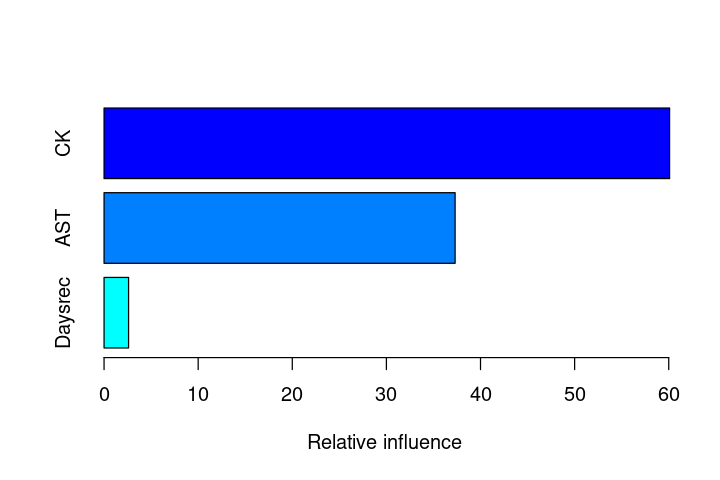

In [15]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbclf_best <- gbm(Outcome ~ ., data= dat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
summary(gbclf_best)


In [41]:
preds <- suppressMessages(predict(gbclf_best, newdata= dat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(dat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbclf_best (400) rcds): ", as.character(ans[[2]]), sep=""))
# f-score on training set: 0.6411

# Accuracy on training set is 0.7425

# Type2 score on training set is 0.6817


    0  1 class.error
0 205 46      0.1833
1  57 92      0.3826


[1] ""

[1] "f-score for gbclf_best (400) rcds): 0.6411"


## More stable training set scores for rfclf_best and gbclf_best

In order to get a better sense of how the random forest and gradient boosting models perform on the training set, we need to average the scores for these models over many different seeds.

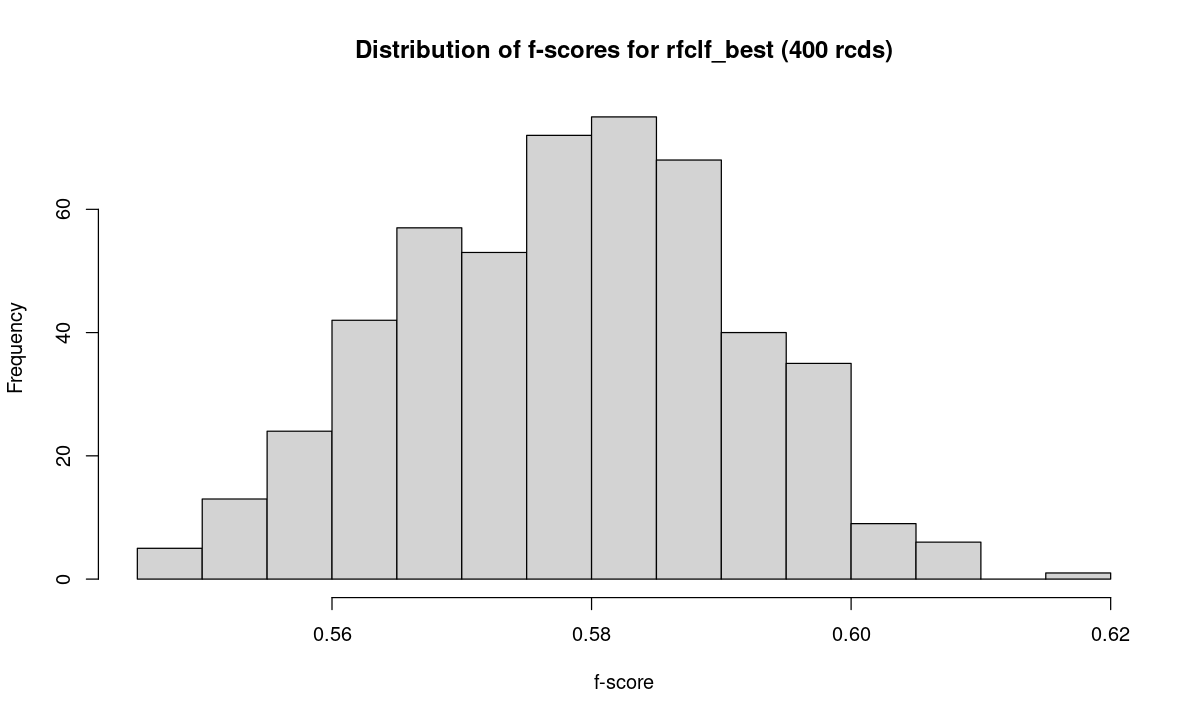

In [49]:
# Get more stable scores for the best random forest model.

set.seed(1433)
seed_smp <- sample(1:9999, 500, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= dat, ntree=160,
                              mtry= 1, nodesize= 1)
        
    mat <- rfmod$confusion
    datout[i, c("Acc")] <- acc <- round(1-median(rfmod$err.rate[,1]), 4)
    datout[i, c("fscore")] <- fscore <- round(get_fscore(mat), 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for rfclf_best (400 rcds)")


In [51]:
# Get summaries for rfclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.5782   
# accuracy:  0.6898   
# false negatives: 65.69   
# false positives: 55.82


[1]  0.5782  0.6898 65.6900 55.8200

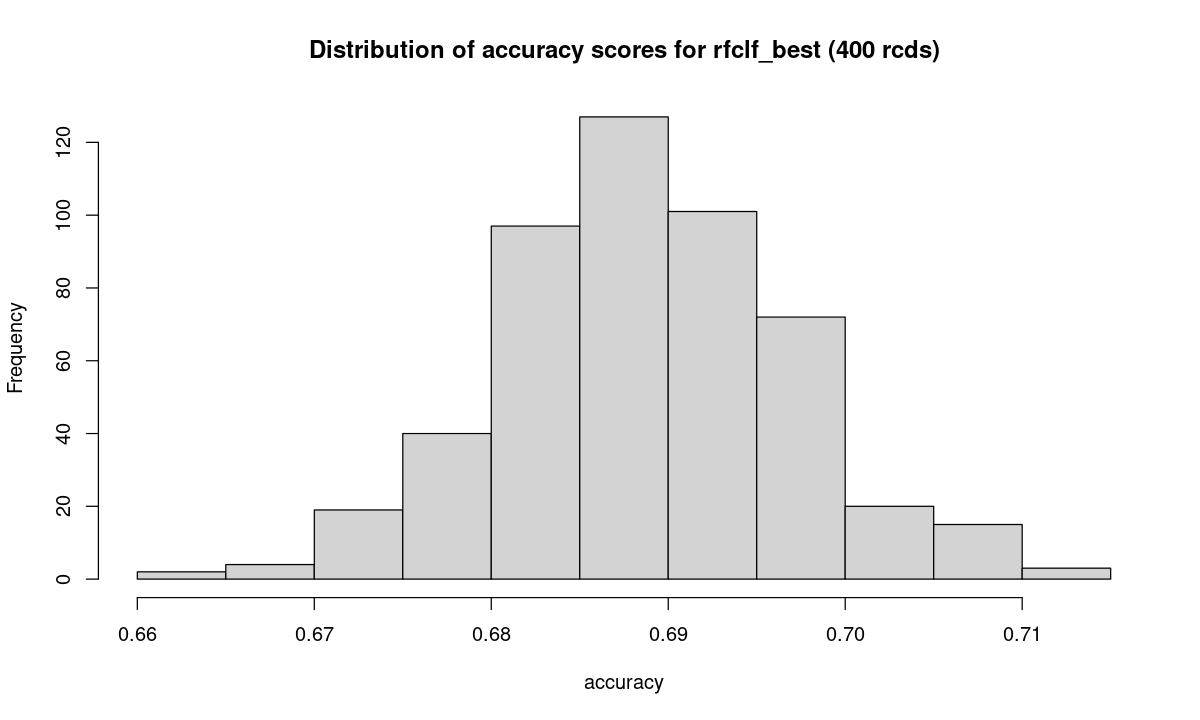

In [52]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=8, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best (400 rcds)")


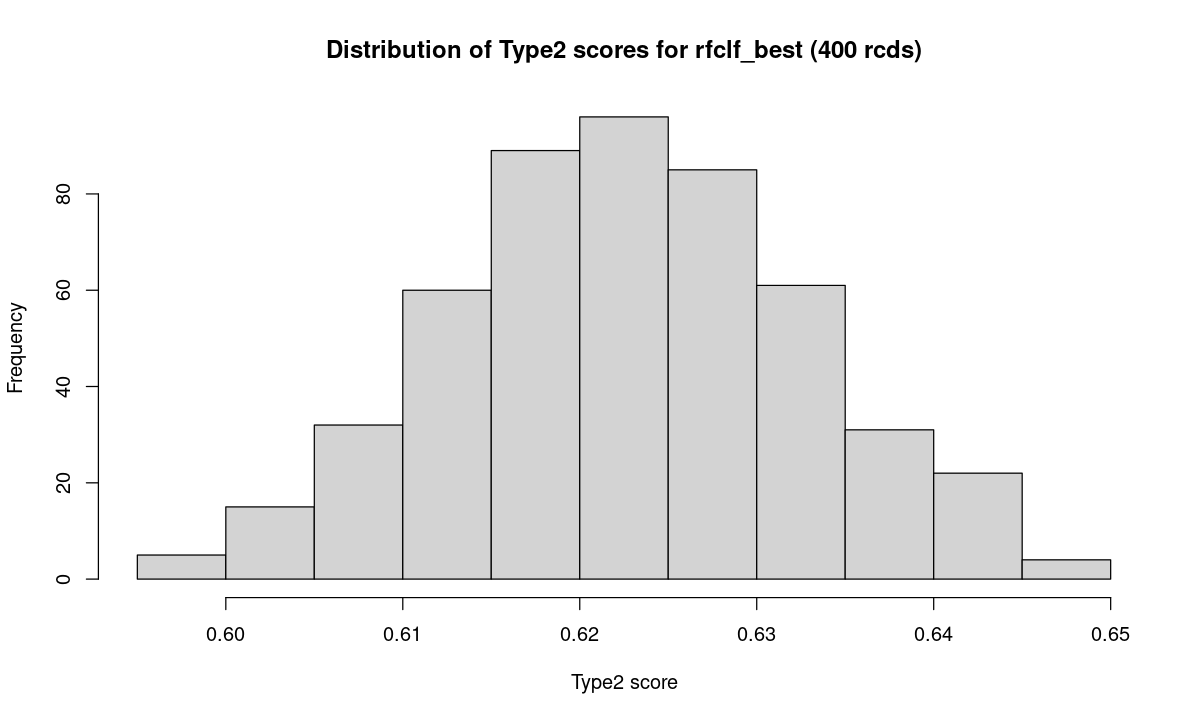

In [53]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for rfclf_best (400 rcds)")
# average Type2 score is 0.6228


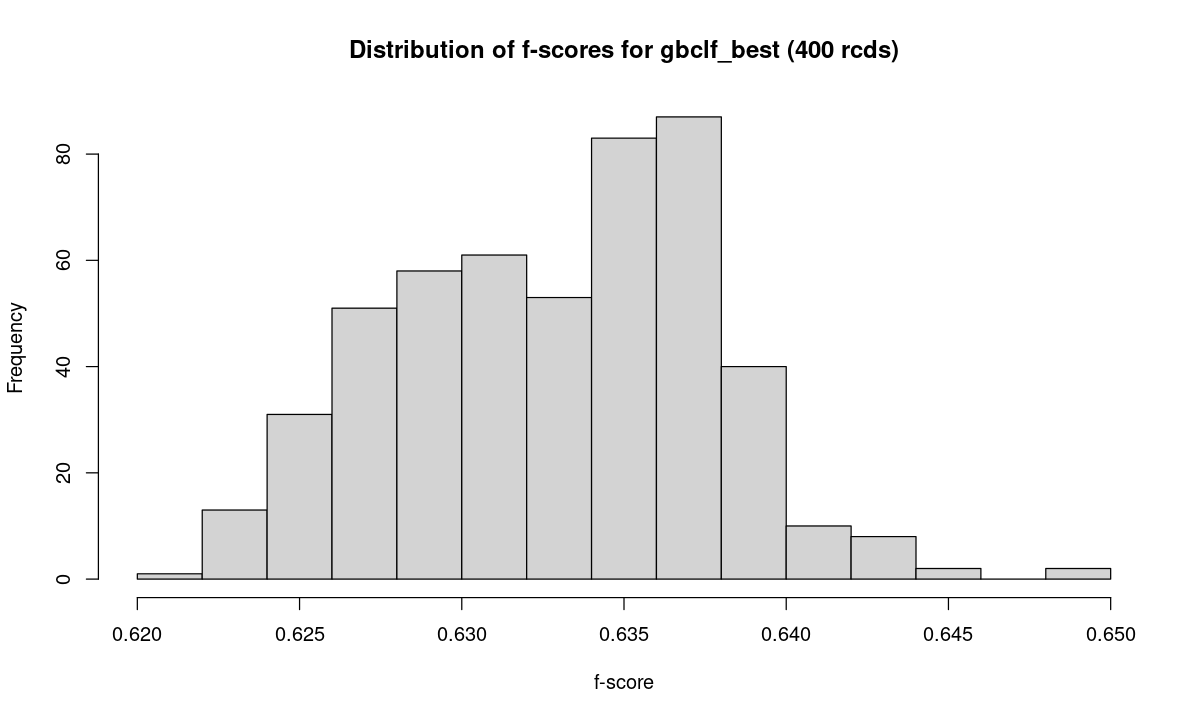

In [13]:
# Get more stable scores for the best gradient 
# boosting model.

set.seed(1433)
seed_smp <- sample(1:9999, 500, replace=FALSE)

datout <- rep(NA, 5 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 5)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed", "fscore","Acc","FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    gbmod <- gbm(Outcome ~ ., data= dat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
        
    preds <- suppressMessages(predict(gbmod, newdata= dat, type="response"))
    preds_transf <- preds
    names(preds_transf) <- rownames(dat)
    preds_transf[which(preds_transf >= 0.5)] <- 1
    preds_transf[which(preds_transf < 0.5)] <- 0
    preds_transf <- as.factor(preds_transf)
    ans <- get_confusion(preds_transf, dat[, "Outcome", drop=FALSE])
    
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for gbclf_best (400 rcds)")


In [57]:
# Get summaries for gbclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.6329   
# accuracy:  0.7338   
# false negatives: 57.23   
# false positives: 49.24

# Average Type2 score is 0.6733.


[1]  0.6329  0.7338 57.2300 49.2400

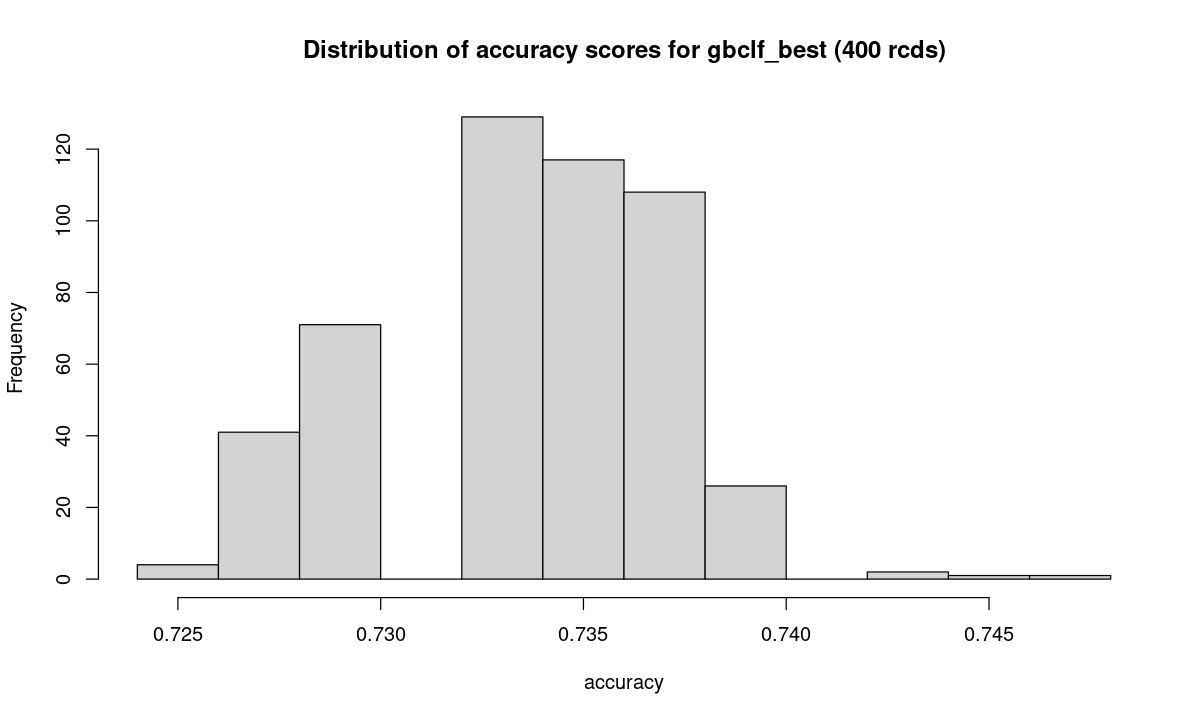

In [14]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=10, xlab="accuracy",
     main="Distribution of accuracy scores for gbclf_best (400 rcds)")


## Get comparative cross-val score for rfclf_best

For model performance comparisons, we want cross-val scores for each of our models over many folds.

In [41]:
# This function is called from get_cvScore_rfBest.  It
# returns a Type2 score on validation data, the score 
# averaged over the number of seeds in seedv02.  In the 
# measurement I take below, seedv02 has 500 seeds.

get_Type2_rfBest <- function(traindat, valdat, seedv02) {
    
    seedv02_len <- length(seedv02)
    outv <- rep(NA, seedv02_len)
    for(i in 1:seedv02_len) {
        
        set.seed(seedv02[i])
        # This is our current best rf model.
        rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= traindat, ntree=160,
                              mtry= 1, nodesize= 1)
        
        preds <- predict(rfmod, newdata= valdat, type="response")
        ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])
        mat <- as.matrix(ans[[1]])
        acc <- sum(diag(mat))/floor(sum(mat))
        outv[i] <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    }
    return(mean(outv))
}


In [44]:
# Function to obtain a cross-validation Type2 score, averaging
# the scores of the folds.  This function is called from
# compute_cvScore_rf.

get_cvScore_rfBest <- function(seed, dat, seedv02, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_rfBest, train_list, test_list,
                       MoreArgs=list(seedv02=seedv02),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The following mean is over 5 measurements (one for each
    # of the folds), but each of these measurements is an
    # average over 500 seeds.
    return(round(mean(scores), 5))
}


In [36]:
# Function to get a cross-val Type2 score over many 
# folds for the best random forest model.

compute_cvScore_rf <- function(seedv, dat, seedv02) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # accuracy score.
        result[i] <- get_cvScore_rfBest(cur.seed, dat, seedv02)
    }
    ans <- round(mean(result), 4)
    return(ans)
}


In [46]:
# Use 500 seeds for seedv02 and 60 seeds for seedv.  
# This means that our score is over 300 folds, where
# the measurement on each fold is taken over 500 
# seeds. 

set.seed(1931)
seedv02 <- sample(1:9999, 500, replace=FALSE)
seedv <- sample(1:9999, 60, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_rf(seedv, dat, seedv02)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 12.77 mins

paste0("Cross-val Type2 score for rfclf_best: ", as.character(ans))
# 'Cross-val Type2 score for rfclf_best: 0.6201'


[1] "Start time: 2021-05-24 09:21:57"

Time difference of 12.77 mins

[1] "Cross-val Type2 score for rfclf_best: 0.6201"

## Get comparative cross-val score for gbclf_best

In [58]:
# This function is called from get_cvScore_gbBest. 

get_Type2_gbBest <- function(traindat, valdat, seedv02) {
    
    seedv02_len <- length(seedv02)
    outv <- rep(NA, seedv02_len)
    for(i in 1:seedv02_len) {
        
        set.seed(seedv02[i])
        # This is our current best gradient boosting model.
        gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
        
        preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
        names(preds) <- rownames(valdat)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        acc <- sum(diag(mat))/floor(sum(mat))
        outv[i] <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    }
    return(mean(outv))
}


In [59]:
# Function to obtain a cross-validation Type2 score for our
# current best gradient boosting model, averaging the
# scores of the folds.  This function is called from
# compute_cvScore_gb.

get_cvScore_gbBest <- function(seed, dat, seedv02, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_gbBest, train_list, test_list,
                       MoreArgs=list(seedv02=seedv02),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The following mean is over 5 measurements (one for each
    # of the folds), but each of these measurements is an
    # average over 500 seeds.
    return(round(mean(scores), 5))
}


In [49]:
# Function to get a cross-val Type2 score over many 
# folds for the best gradient boosting model.

compute_cvScore_gb <- function(seedv, dat, seedv02) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # accuracy score.
        result[i] <- get_cvScore_gbBest(cur.seed, dat, seedv02)
    }
    ans <- round(mean(result), 4)
    return(ans)
}


In [61]:
# Use 500 seeds for seedv02 and 60 seeds for seedv.  
# This means that our score is over 300 folds, where
# the measurement on each fold is taken over 500 
# seeds. 

set.seed(1931)
seedv02 <- sample(1:9999, 500, replace=FALSE)
seedv <- sample(1:9999, 60, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_gb(seedv, dat, seedv02)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.82 mins

paste0("Cross-val Type2 score for gbclf_best: ", as.character(ans))
# 'Cross-val Type2 score for gbclf_best: 0.6488'


[1] "Start time: 2021-05-24 09:51:18"

Time difference of 3.82 mins

[1] "Cross-val Type2 score for gbclf_best: 0.6488"

In [ ]:
### COMMENT:

# The average cross-val Type2 score for gbclf_best is almost
# 3 percentage points greater than the same score for rfclf_best.


## SVM classifier

In [62]:
# For SVM modeling, we need to scale the data.

# NOTE: we get a better svm model if we do not apply
# any prior transformations to the variables (such as
# taking the log or sqrt).

svmtrain <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(svmtrain$Outcome, svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [61]:
# I am interested in using the radial basis function 
# as the kernel.

svm01 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.01, cost= 40, scale=FALSE)

pred <- fitted(svm01)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
get_fscore(as.matrix(ans))


    
pred   0   1
   0 188  53
   1  63  96

[1] 0.6234

In [ ]:
#&* Bookmark

In [16]:
# Function to compute a Type2 score for an svm cv-fold.

get_Type2_svm <- function(traindat, valdat, gamma, cost) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(cbind(valdat$Outcome,test_scaled), 
                                 row.names=rownames(valdat))
    colnames(test_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(result)
}


In [17]:
# This grid search searches for the best parameters for svm
# modeling of the data. 

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the Type2 score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                names(row_list) <- as.character(1:folds)
                startpt <- 1
                for(k in 1:folds) {
                    endpt <- startpt + segmentsv[k] - 1
                    stopifnot(endpt <= nrow(dat))
                    row_list[[k]] <- rownames(dat)[startpt:endpt]
                    startpt <- endpt + 1
                }
                
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_Type2_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the Type2
                # scores, the average taken over the folds.
                seed_scores[h] <- round(mean(scores), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Type2[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [ ]:
# Run grid search to get better parameters for the 
# svm classifier.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.1, 0.3, by=0.05)
cost_v <- seq(100, 500, by=100)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, dat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.69 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.1--100'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6376


In [19]:
# Refine the grid search.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.01, 0.1, by=0.01)
cost_v <- seq(20, 100, by=20)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, dat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.29 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.01--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6579


[1] "Start time: 2021-04-13 14:34:38"

Time difference of 5.63 mins

[1] "0.01--20"

[1] 0.6579

In [20]:
# Again, refine the search.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.002, 0.01, by=0.002)
cost_v <- seq(5, 20, by=5)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, dat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.11 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.01--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6579


[1] "Start time: 2021-04-13 14:42:06"

Time difference of 2.26 mins

character(0)

numeric(0)

In [21]:
(best_params <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$params)
# '0.008--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$Type2)
# 0.6593


[1] "0.008--20"

[1] 0.65927

### Get training set scores for best svm (svm02)

In [28]:
# Construct an svm with the identified parameters.

# We need to get probability estimates from the output.
# So we set probability=TRUE.
svm02 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)

pred <- fitted(svm02)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
print(paste("f-score for 'best' svm classifier (400 rcds): ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# f-score for the training set: 0.6502

# Accuracy for the training set is 0.7175

# Type2 score for the training set is 0.6771


    
pred   0   1
   0 182  44
   1  69 105

[1] "f-score for 'best' svm classifier (400 rcds): 0.6502"


## Get comparative cross-val score for svm02

In [66]:
# This function is called from get_cvScore_svm02. 

get_Type2_svm02 <- function(traindat, valdat) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers, scale=train_scales)
    test_scaled <- as.data.frame(test_scaled, row.names=rownames(valdat))
    
        
    # This is our current best svm model.
    svm_mod <- svm(I(as.factor(Outcome)) ~ ., data=train_scaled, kernel="radial",
                   gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds <- predict(svm_mod, newdata= test_scaled)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(as.factor(preds), valdat[, "Outcome", drop=FALSE])
        
    mat <- as.matrix(ans[[1]])
    acc <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * acc + 0.6 * ans[[2]]), 4)

    return(result)
}


In [69]:
# Function to obtain a cross-validation Type2 score for our
# current best svm model, averaging the scores of the folds.  
# This function is called from compute_cvScore_svm02.

get_cvScore_svm02 <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_svm02, train_list, test_list,
                       SIMPLIFY= TRUE, mc.cores=5)
    return(round(mean(scores), 5))
}


In [72]:
# Function to get a cross-val Type2 score over many 
# folds for the best svm model.

compute_cvScore_svm02 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # Type2 score.
        result[i] <- get_cvScore_svm02(cur.seed, dat)
    }
    ans <- round(mean(result, na.rm=TRUE), 4)
    return(ans)
}


In [73]:
# Compute a cross-val Type2 score over 5000 folds.

set.seed(1931)
seedv <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_svm02(seedv, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 38 secs

paste0("Cross-val Type2 score for svm02: ", as.character(ans))
# 'Cross-val Type2 score for svm02: 0.6602'


[1] "Start time: 2021-05-24 11:16:55"

Time difference of 37.71 secs

[1] "Cross-val Type2 score for svm02: 0.6602"

## Final Comments for Section 1

svm02 has the best Type2 cross-val score.  It is one percentage point higher than that for gbclf_best.  svm02's Type2 cross-val score is four percentage points higher than that for rfclf_best.  The same score is computed for g03 below; our best logistic regression classifier has a Type2 cross-val score of 0.657.


                                        * * * * *


# Section 2: Construct a k-means base model

## Get training set scores for base k-means model

In [17]:
# Scale the data first.

df <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
df$AST <- log(df$AST)
df$CK <- log(df$CK)
df$Daysrec <- sqrt(df$Daysrec)

df_scaled <- scale(df[, -1])
centers <- attr(df_scaled, "scaled:center")
scales <- attr(df_scaled, "scaled:scale")

df_scaled <- as.data.frame(cbind(dat$Outcome, df_scaled),
                           row.names=rownames(dat))
colnames(df_scaled) <- colnames(df)
summary(df_scaled)


    Outcome           AST                CK             Daysrec       
 Min.   :0.000   Min.   :-2.1314   Min.   :-3.0256   Min.   :-1.2537  
 1st Qu.:0.000   1st Qu.:-0.7577   1st Qu.:-0.6954   1st Qu.:-1.2537  
 Median :0.000   Median :-0.0436   Median : 0.0123   Median :-0.0179  
 Mean   :0.372   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:1.000   3rd Qu.: 0.7037   3rd Qu.: 0.6789   3rd Qu.: 0.8867  
 Max.   :1.000   Max.   : 2.4651   Max.   : 2.3078   Max.   : 2.0157  

In [18]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
fit_km <- kmeans(df_scaled, 2, iter.max = 50, nstart = 30)
print(fit_km$size)
# [1] 175   145


[1] 184 216


In [19]:
datout <- as.data.frame(cbind(df_scaled$Outcome, fit_km$cluster))
colnames(datout) <- c("Outcome", "cluster")
rownames(datout) <- rownames(df_scaled)
head(datout)


,Outcome,cluster
,<dbl>,<dbl>
435,0,2
327,1,2
300,0,1
269,0,1
158,0,2
54,0,2


In [20]:
# max_vals identifies the Outcome level we would expect 
# each cluster to map to.

(mat <- as.matrix(table(datout$Outcome, as.factor(datout$cluster))))
max_vals <- apply(mat, MARGIN=2, which.max); print(max_vals)


   
      1   2
  0  75 176
  1 109  40

1 2 
2 1 


In [21]:
# Use function c1_toLevel_1 to get the correct 
# mapping between clusters and Outcome levels.

c1_to_Outcome1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Outcome level 1? :  ", c1_to_Outcome1, sep="")


[1] "Map cluster 1 to Outcome level 1? :  TRUE"

In [22]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
dim(tmpdat)


[1] 400   2

In [23]:
sum(rownames(tmpdat) == rownames(df_scaled)) == nrow(df_scaled)


[1] TRUE

In [24]:
table(as.factor(tmpdat$Outcome))



  0   1 
216 184 

In [25]:
# Generate confusion matrix for the k-means clusters.
# Output f-score for this confusion matrix.

preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means (400 rcds): ", as.character(ans[[2]]), sep=""))
# f-score on the training set is 0.6547

# Accuracy on the training set is 0.7125

# Type2 score on the training set is 0.6778


    0   1 class.error
0 176  75      0.2988
1  40 109      0.2685


[1] ""

[1] "f-score for k-means (400 rcds): 0.6547"


## Get comparative cross-val score for the base k-means model

In [74]:
# This function is called from get_cvScore_svm02. 

get_Type2_kmBase <- function(traindat, valdat) {
    
    # Scale traindat.
    df <- traindat
    df$AST <- log(df$AST)
    df$CK <- log(df$CK)
    df$Daysrec <- sqrt(df$Daysrec)

    df_scaled <- scale(df[, -1])
    centers <- attr(df_scaled, "scaled:center")
    scales <- attr(df_scaled, "scaled:scale")
    
    
    # Scale valdat.
    df2 <- valdat
    df2$AST <- log(df2$AST)
    df2$CK <- log(df2$CK)
    df2$Daysrec <- sqrt(df2$Daysrec)
    test_scaled <- scale(df2[, -1], center=centers, scale=scales)
    test_scaled <- as.data.frame(test_scaled, row.names=rownames(valdat))
    
        
    # Construct k-means model and get mapping.
    km_mod <- kmeans(df_scaled, 2, iter.max = 50, nstart = 30)
    
    datout <- as.data.frame(cbind(traindat$Outcome, km_mod$cluster),
                            row.names=rownames(traindat))
    colnames(datout) <- c("Outcome", "cluster")
    c1_to_Outcome1 <- c1_toLevel_1(datout)
    
    ##############################################
    # Apply the k-means model to test_scaled.
    
    # Each element of the following list is a row of test_scaled.
    valdat_asList <- split(test_scaled[, colnames(km_mod$centers)],
                           seq(nrow(valdat)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- km_mod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    test_scaled$cluster <- as.numeric(cluster_assgns)
    
    test_scaled$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        test_scaled[which(test_scaled$cluster==1),]$pred_Outcome <- 1
        test_scaled[which(test_scaled$cluster==2),]$pred_Outcome <- 0
    } else {
        test_scaled[which(test_scaled$cluster==1),]$pred_Outcome <- 0
        test_scaled[which(test_scaled$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(test_scaled$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])
        
    mat <- as.matrix(ans[[1]])
    acc <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    return(result)
}


In [75]:
# Function to obtain a cross-validation Type2 score for our
# base k-means model, averaging the scores of the folds.  
# This function is called from compute_cvScore_kmBase.

get_cvScore_kmBase <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_kmBase, train_list, test_list,
                       SIMPLIFY= TRUE, mc.cores=5)
    return(round(mean(scores), 5))
}


In [76]:
# Function to get a cross-val Type2 score over many 
# folds for the base k-means model.

compute_cvScore_kmBase <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # Type2 score.
        result[i] <- get_cvScore_kmBase(cur.seed, dat)
    }
    ans <- round(mean(result, na.rm=TRUE), 4)
    return(ans)
}


In [80]:
# Compute a cross-val Type2 score over 5000 folds.

set.seed(1931)
seedv <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_kmBase(seedv, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.71 mins

paste0("Cross-val Type2 score for base k-means: ", as.character(ans))
# 'Cross-val Type2 score for base k-means: 0.6532'


[1] "Start time: 2021-05-24 12:02:26"

Time difference of 3.71 mins

[1] "Cross-val Type2 score for base k-means: 0.6532"

In [ ]:
### COMMENTS:

# The base k-means model, without weights, has a better Type2
# cross-val score than our best random forest model and our
# best gradient boosting model.  Our best logistic regression
# model has a slightly better score (0.6572).  svm02's score
# was 0.6602.


# Section 3: Construct hybrid model using svm02 probabilities

Can we improve the base k-means model by giving it the outcome of the svm02 model?

In [81]:
# Prepare the data.

# For SVM modeling, we need to scale the data.

svmdf <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
svm_scaled <- scale(svmdf[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(svmdf$Outcome, svm_scaled),
                            row.names=rownames(svmdf))
colnames(svm_scaled) <- colnames(svmdf)


df <- dat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
# Transformations used in the k-means modeling.
df$AST <- log(df$AST)
df$CK <- log(df$CK)
df$Daysrec <- sqrt(df$Daysrec)

preds01 <- predict(svm02, newdata=svm_scaled, scale=FALSE, probability=TRUE)
df$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])

# Previous testing shows that we want to also scale the 
# prob01 column.
df_scaled <- scale(df[, -1])
centers <- attr(df_scaled, "scaled:center")
scales <- attr(df_scaled, "scaled:scale")

df_scaled <- as.data.frame(cbind(dat$Outcome, df_scaled),
                              row.names=rownames(dat))
colnames(df_scaled) <- colnames(df)
summary(df_scaled[, -1])


      AST                CK             Daysrec            prob01      
 Min.   :-2.1314   Min.   :-3.0256   Min.   :-1.2537   Min.   :-1.660  
 1st Qu.:-0.7577   1st Qu.:-0.6954   1st Qu.:-1.2537   1st Qu.:-0.842  
 Median :-0.0436   Median : 0.0123   Median :-0.0179   Median : 0.104  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.000  
 3rd Qu.: 0.7037   3rd Qu.: 0.6789   3rd Qu.: 0.8867   3rd Qu.: 0.952  
 Max.   : 2.4651   Max.   : 2.3078   Max.   : 2.0157   Max.   : 1.479  

In [82]:
print(head(df$prob01))
""
summary(df$prob01)


[1] 0.0903645 0.3035411 0.5392841 0.6284817 0.2493598 0.0041255


[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0003  0.1818  0.3917  0.3687  0.5800  0.6970 

In [31]:
# Construct model with the new prob01 column.

set.seed(1233)
kmod <- kmeans(df_scaled[, -1], 2, iter.max = 50, nstart = 25)


In [32]:
# Get the mapping between clusters and Outcome levels.

dfout <- as.data.frame(cbind(as.numeric(df_scaled$Outcome), kmod$cluster),
                       row.names=rownames(df_scaled))
colnames(dfout) <- c("Outcome", "cluster")

tmpdat <- dfout

c1_to_Outcome1 <- c1_toLevel_1(dfout)
        
if(c1_to_Outcome1) {
    # cluster 1 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
} else {
    # cluster 2 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
}


In [33]:
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.

preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, df_scaled[, "Outcome", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans (w/ p1), (400 rcds): ", as.character(ans[[2]]), sep=""))
# [1] "f-score for kmeans (w/ p1), (400 rcds): 0.6325"


mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans (w/ p1), (400 rcds): ", as.character(result), sep=""))
# [1] "Type2 score for kmeans (w/ p1), (400 rcds): 0.6505"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.6775"

# These are scores on the training set.


    0   1 class.error
0 160  91      0.3625
1  38 111      0.2550


[1] ""

[1] "f-score for kmeans (w/ p1), (400 rcds): 0.6325"


[1] ""

[1] "Type2 score for kmeans (w/ p1), (400 rcds): 0.6505"


[1] ""

[1] "Accuracy: 0.6775"


In [ ]:
### COMMENT:

# The base k-means model has better scores than this hybrid
# model.  E.g., the accuracy is 3.5 percentage points greater
# than what we see here.


## Add weights to the hybrid k-means model

We should be able to improve the hybrid model by adding weights to it.

In [ ]:
#&* Bookmark

In [15]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1 <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(cbind(valdat$Outcome, svmval_scaled),
                                   row.names=rownames(valdat))
    colnames(svmval_scaled) <- colnames(valdat)
    
    # Compute the prob01 column.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.

    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [108]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.
# Because our training set is so small---only 400 records---we
# need to run the gridSearch over many seeds.  Otherwise, we 
# will not get a meaningful result.

gridSearch06 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Type2")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are Type2 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            ### NOTE: I change the following function call depending on
            ### the model I am scoring.
            scores <- mcmapply(get_cvScore_kmp1p2, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the Type2
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the Type2 scores
    # obtained for each set of parameters in df_params.
    datout$Type2 <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


## Search for the best set of weights for the hybrid model

In [42]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [43]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
11425,0.33,0.27,0.17,0.23
7201,0.35,0.27,0.19,0.19
22165,0.37,0.15,0.15,0.33
20509,0.27,0.21,0.21,0.31
23329,0.25,0.13,0.29,0.33
22057,0.29,0.25,0.13,0.33


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 24.51 secs (for 10 rows)


In [ ]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [52]:
# Find the best weights of those in dfc01 (1469 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 57.46 mins (= 2.3469 secs/row)


[1] "Start time: 2021-04-12 15:28:51"

Time difference of 57.46 mins

In [53]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [54]:
dfc01[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 1777	0.29 	0.25	   0.33 	  0.13


best_Type2
# 0.6598


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
1777,0.29,0.25,0.33,0.13


[1] 0.65982

In [55]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.27, 0.33, by= 0.01)
lst[[2]] <- seq(0.21, 0.29, by= 0.01)
lst[[3]] <- seq(0.31, 0.37, by= 0.01)
lst[[4]] <- seq(0.09, 0.15, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  267     4


[1] 267   4

In [56]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.  (Setting each of the weight 
# coefficients to 1 is essentially equivalent to
# setting each of the 4 weights to 0.25, although
# small differences can appear in the resultant
# score.)  

# NOTE: the result we get from this test is much 
# better than testing against the test set, since
# this test is the equivalent of 100 such tests.

dfc02 <- rbind(dfc02, rep(1,4))


In [58]:
# Find the best weights of those in dfc02 (268 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 12.15 mins


[1] "Start time: 2021-04-12 16:31:17"

Time difference of 12.15 mins

In [59]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [60]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 1103  	0.30 	0.25	   0.34 	  0.11

best_Type2
# 0.66075


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
1103,0.3,0.25,0.34,0.11


[1] 0.66075

In [ ]:
### COMMENTS:

# Notice that the best cross-validation score does 
# not occur when all coefficients, or weights, are
# set to 1.  Thus, the weights are an improvement over
# no weights.


## Get comparative cross-val score for the hybrid model with weights

In [83]:
# This function is called from get_cvScore_p1Hybrid. 

get_Type2_p1Hybrid <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    
    
    #############################
    # Transform and scale training set data for the k-means model.
    
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.30, 0.25, 0.34, 0.11)^0.5
    names(wghts) <- cols <- colnames(traindat_scaled)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
    
    #############################################
    # Scale valdat.
    #############################################
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(cbind(valdat$Outcome, svmval_scaled),
                                   row.names=rownames(valdat))
    colnames(svmval_scaled) <- colnames(valdat)
    
    # Compute the prob01 column.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.

    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    acc <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * acc + 0.6 * ans[[2]]), 6)
    return(result)
}


In [84]:
# Function to obtain a cross-validation Type2 score for the
# k-means hybrid model + weights, averaging the scores of the folds.  
# This function is called from compute_cvScore_p1Hybrid.

get_cvScore_p1Hybrid <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_p1Hybrid, train_list, test_list,
                       SIMPLIFY= TRUE, mc.cores=5)
    return(round(mean(scores), 5))
}


In [85]:
# Function to get a cross-val Type2 score over many 
# folds for the k-means hybrid model (prob01 + weights).

compute_cvScore_p1Hybrid <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # Type2 score.
        result[i] <- get_cvScore_p1Hybrid(cur.seed, dat)
    }
    ans <- round(mean(result, na.rm=TRUE), 4)
    return(ans)
}


In [88]:
# Compute a cross-val Type2 score over 5000 folds.

set.seed(1931)
seedv <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_p1Hybrid(seedv, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.54 mins

paste0("Cross-val Type2 score for hybrid model (prob01 + wghts): ", as.character(ans))
# 'Cross-val Type2 score for hybrid model (prob01 + wghts): 0.658'


[1] "Start time: 2021-05-24 12:50:26"

Time difference of 4.54 mins

[1] "Cross-val Type2 score for hybrid model (prob01 + wghts): 0.658"

## Find weights for k-means base model

In [17]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmBase <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, and Daysrec.)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [67]:
# There are 3 parameter lists to work with.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- lst[[2]] <- lst[[3]] <- seq(0.15, 0.55, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst, tol=0.0001)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
# 1236    3


[1] 1236    3

In [68]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc04), 10, replace=FALSE)
tst_params <- dfc04[smp,]


In [69]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
# round(stop - start, 2)
# Time difference of 15 secs (for 10 rows)


In [ ]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc04[best_params,]

best_Type2


In [72]:
# Find the best weights of those in dfc01 (1236 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 45.81 mins


[1] "Start time: 2021-04-12 16:58:05"

Time difference of 45.81 mins

In [73]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [74]:
dfc04[best_params,]
#   	 AST 	  CK  	Daysrec 

# 656 	0.55 	0.30	   0.15


best_Type2
# 0.6619


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
656,0.55,0.3,0.15


[1] 0.6619

In [75]:
# There are 3 parameter lists to work with.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- seq(0.55, 0.62, by=0.01)
lst[[2]] <- seq(0.27, 0.33, by=0.01)
lst[[3]] <- seq(0.05, 0.15, by=0.01)

start <- Sys.time()
dfc05 <- generate_combs(lst, tol=0.0001)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc05)
# 50    3


[1] 50  3

In [76]:
# Find the best weights of those in dfc01 (50 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.83 mins


[1] "Start time: 2021-04-12 17:49:51"

Time difference of 1.83 mins

In [77]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [78]:
dfc05[best_params,]
#   	 AST 	  CK  	Daysrec 

# 509 	0.59 	0.27	   0.14


best_Type2
# 0.664


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
509,0.59,0.27,0.14


[1] 0.664

In [80]:
# There are 3 parameter lists to work with.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- seq(0.57, 0.62, by=0.01)
lst[[2]] <- seq(0.22, 0.27, by=0.01)
lst[[3]] <- seq(0.11, 0.18, by=0.01)

start <- Sys.time()
dfc06 <- generate_combs(lst, tol=0.0001)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc06)
# 1236    3


[1] 30  3

In [81]:
# Find the best weights of those in dfc01 (30 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.05 mins


[1] "Start time: 2021-04-12 17:56:47"

Time difference of 1.05 mins

In [82]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [83]:
dfc06[best_params,]
#   	 AST 	  CK  	Daysrec 

# 141 	0.59 	0.27	   0.14


best_Type2
# 0.664


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
141,0.59,0.27,0.14


[1] 0.664

In [86]:
# See whether the above weights are better 
# than no weights.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- c(0.59)
lst[[2]] <- c(0.27)
lst[[3]] <- c(0.14)

start <- Sys.time()
dfc07 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

(dfc07 <- rbind(dfc07, rep(1, 3)))


AST,CK,Daysrec
<dbl>,<dbl>,<dbl>
0.59,0.27,0.14
1.00,1.00,1.00


In [88]:
# Find the best weights of those in dfc05 ( rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc07) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 secs


[1] "Start time: 2021-04-12 18:04:55"

Time difference of 3.84 secs

In [89]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [90]:
dfc07[best_params,]
#       	 AST 	  CK  	Daysrec

# 1     	0.59 	0.27	   0.14

best_Type2
# 0.664


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
1,0.59,0.27,0.14


[1] 0.664

## Get comparative cross-val score for base k-means with weights

In [89]:
# This function is called from get_cvScore_kmBaseWghts. 

get_Type2_kmBaseWghts <- function(traindat, valdat) {
    
    # Transform and scale traindat.
    
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.59, 0.27, 0.14)^0.5
    names(wghts) <- cols <- colnames(traindat_scaled)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    

    #############################################
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.

    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    acc <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * acc + 0.6 * ans[[2]]), 6)
    return(result)
}


In [90]:
# Function to obtain a cross-validation Type2 score for the 
# base k-means model + weights, averaging the scores of the folds.  
# This function is called from compute_cvScore_kmBaseWghts.

get_cvScore_kmBaseWghts <- function(seed, dat, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_Type2_kmBaseWghts, train_list, test_list,
                       SIMPLIFY= TRUE, mc.cores=5)
    return(round(mean(scores), 5))
}


In [91]:
# Function to get a cross-val Type2 score over many 
# folds for the k-means base model + weights.

compute_cvScore_kmBaseWghts <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    result <- rep(NA, length=seedv_len)
    names(result) <- as.character(seedv)
    
    for(i in 1:seedv_len) {
        cur.seed <- seedv[i]
        # For each seed in seedv, compute a cross-val
        # Type2 score.
        result[i] <- get_cvScore_kmBaseWghts(cur.seed, dat)
    }
    ans <- round(mean(result, na.rm=TRUE), 4)
    return(ans)
}


In [94]:
# Compute a cross-val Type2 score over 5000 folds.

set.seed(1931)
seedv <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- compute_cvScore_kmBaseWghts(seedv, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.54 mins

paste0("Cross-val Type2 score for k-means base model + wghts: ", as.character(ans))
# 


[1] "Start time: 2021-05-24 13:19:35"

Time difference of 3.79 mins

[1] "Cross-val Type2 score for k-means base model + wghts: 0.6602"

In [ ]:
### COMMENTS:

# The base k-means model works best with weights.
# With weights, we have a cross-validation Type2 score,
# averaged over 5000 folds, of 0.6602.  This is the
# same Type2 cross-val score that we saw for the svm02
# model.

# Without the weights, the Type2 cross-val score for
# the base k-means model was 0.6532.  So the weights
# yielded a gain of 0.0070 in the Type2 score.

# The Type2 cross-val score for the hybrid model with
# weights and the prob01 column constructed from svm02
# was 0.6580.


## Section 3 Comments 

When computed over 1000 seeds (5000 folds):

(1) base k-means + weights has a Type2 of 0.6602

(2) k-means + prob01 + weights has a Type2 of 0.6580

(3) svm02 has a Type2 of 0.6602.


The aim, of course, is to find a hybrid model with a Type2 cross-val score greater than 0.6602.


                                  * * * * * 

# Section 4: Construct hybrid model with 2 probability columns

As in Part 1, I will use gbclf_best for the prob02 probabilities.

In [107]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1p2 <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(preds02)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(cbind(valdat$Outcome, svmval_scaled),
                                   row.names=rownames(valdat))
    colnames(svmval_scaled) <- colnames(valdat)
    
    # Compute prob01 and prob02.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat_wghts)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


### Search for the best set of weights: hybrid model with prob01, prob02

In [19]:
# There are 5 parameter lists to work with.  Again, the
# best approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.14, 0.26, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1451     5


[1] 1451    5

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 27 secs (for 10 rows)


In [ ]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [25]:
# Find the best weights of those in dfc01 (1451 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.08 hours


[1] "Start time: 2021-04-13 07:06:37"

Time difference of 1.08 hours

In [26]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [27]:
dfc01[best_params,]
#   	     AST 	  CK  	Daysrec 	prob01  	prob02

# 7162  	0.14 	0.16	   0.26 	  0.26  	  0.18


best_Type2
# 0.64649


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7162,0.14,0.16,0.26,0.26,0.18


[1] 0.64649

In [28]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.08, 0.18, by= 0.02)
lst[[2]] <- seq(0.10, 0.20, by= 0.02)
lst[[3]] <- seq(0.22, 0.32, by= 0.02)
lst[[4]] <- seq(0.22, 0.32, by=0.02)
lst[[5]] <- seq(0.12, 0.22, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  780     5


[1] 780   5

In [29]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.  

dfc02 <- rbind(dfc02, rep(1,5))


In [31]:
# Find the best weights of those in dfc02 (781 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 34.79 mins


[1] "Start time: 2021-04-13 08:24:51"

Time difference of 34.79 mins

In [32]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [33]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#  824  	0.10 	0.20	   0.30 	  0.28  	  0.12

best_Type2
# 0.65227


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
824,0.1,0.2,0.3,0.28,0.12


[1] 0.65227

In [35]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.07, 0.12, by= 0.01)
lst[[2]] <- seq(0.18, 0.22, by= 0.01)
lst[[3]] <- seq(0.28, 0.33, by= 0.01)
lst[[4]] <- seq(0.26, 0.31, by=0.01)
lst[[5]] <- seq(0.09, 0.13, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  578     5


[1] 578   5

In [36]:
# Find the best weights of those in dfc02 (578 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 30 mins


[1] "Start time: 2021-04-13 09:10:13"

Time difference of 30.09 mins

In [37]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [38]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 4461  	0.07 	0.22	   0.33 	  0.26  	  0.12

best_Type2
# 0.65344


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3415,0.07,0.22,0.33,0.26,0.12


[1] 0.65344

In [39]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.04, 0.08, by= 0.01)
lst[[2]] <- seq(0.20, 0.24, by= 0.01)
lst[[3]] <- seq(0.31, 0.35, by= 0.01)
lst[[4]] <- seq(0.23, 0.27, by=0.01)
lst[[5]] <- seq(0.10, 0.14, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
#  320     5


[1] 320   5

In [40]:
# Find the best weights of those in dfc02 (320 rows,
# 11 seeds, 5 folds).

set.seed(42)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 17.02 mins


[1] "Start time: 2021-04-13 09:44:58"

Time difference of 17.02 mins

In [41]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [42]:
dfc04[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 869   	0.07 	0.23	   0.35 	  0.24  	  0.11

best_Type2
# 0.6558


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
869,0.07,0.23,0.35,0.24,0.11


[1] 0.65577

### Cross-val score for hybrid model (p1 + p2), 1000 seeds

This is quick and dirty way to get a cross-val score.  It is not as good as the method I have been using because it does not allow for a deeper analysis of the distribution of values making up the final score.  To get that distribution, I would have to alter gridSearch06.

In [95]:
lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- c(0.07)
lst[[2]] <- c(0.23)
lst[[3]] <- c(0.35)
lst[[4]] <- c(0.24)
lst[[5]] <- c(0.11)

dfc06 <- generate_combs(lst)


In [109]:
# Make sure gridSearch06 calls get_cvScore_kmp1p2.

set.seed(42)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.21 mins


[1] "Start time: 2021-05-24 14:12:20"

Time difference of 5.21 mins

In [110]:
dat_result
# Type2 score of 0.6527


row,Type2
<chr>,<dbl>
1,0.6527


## Section 4 Comments

Adding a second probability column does not improve the model.  With our previous 1000-seed tests (base k-means model, svm02, and k-means with prob01), the cross-validation score was closer to 0.6600.

# Section 5: Get summary info for each model; use 1000 seeds

In [47]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with both probability columns.

get_cvScores_kmp1p2 <- function(traindat, valdat) {
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(preds02)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.07, 0.23, 0.35, 0.24, 0.11)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01","prob02")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute prob01 and prob02.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # Map the clusters to Outcome levels.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [106]:
# This function returns 5 cross-validation metrics for each
# seed in the seed vector, seedv.

get_cvInfo <- function(seedv, dat, folds=5) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * folds * seedv_len)
    dim(datout) <- c((seedv_len*folds), 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    # For each seed we record 5 sets of cross-val scores
    prefixes <- rep(as.character(seedv), rep(folds, seedv_len))
    suffixes <- rep(paste(1:folds), seedv_len)
    seed_names <- paste(prefixes, suffixes, sep="--")
    rownames(datout) <- seed_names
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
    
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(k in 1:folds) {
            endpt <- startpt + segmentsv[k] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[k]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
        
        train_list <- test_list <- vector("list", length= folds)
        for(j in 1:folds) {
            testdat <- dat[row_list[[j]],]
            traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
            stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
            test_list[[j]] <- testdat
            train_list[[j]] <- traindat
        }
        # When there are only 5 folds, only 5 cores get used.
        ### NOTE: the function on the right-hand side changes depending
        ### the model for which we want summary info.
        scores <- mcmapply(get_cvScores_kmp1p2_v02, train_list, test_list,
                           SIMPLIFY= "array", mc.cores=5)
        
        for(k in 1:folds) {
            row_name <- paste(as.character(cur_seed), k, sep="--")
            datout[row_name, 1:5] <- scores[, k]
        }

    } ## end of for-loop, index h
    
    return(datout)
}


In [50]:
# Get scores for the hybrid model with prob01 and prob02.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.6 mins


Time difference of 4.6 mins

In [51]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5455,0.6875,0.6023,7,18
4782--2,0.6230,0.7125,0.6588,9,14
4782--3,0.5484,0.6500,0.5890,13,15
4782--4,0.6829,0.6750,0.6797,4,22
4782--5,0.7105,0.7250,0.7163,10,12
9275--1,0.6129,0.7000,0.6477,11,13


## Summary info for hybrid model with prob01, prob02

In [52]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6282
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0632
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6282"

[1] "fscore StdDev: 0.0632"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.370   0.587   0.632   0.628   0.675   0.818 

In [53]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6899
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0469
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6899"

[1] "accuracy StdDev: 0.0469"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.525   0.662   0.688   0.690   0.725   0.850 

In [54]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6528
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0543
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6528"

[1] "Type2 StdDev: 0.0543"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.442   0.617   0.655   0.653   0.691   0.831 

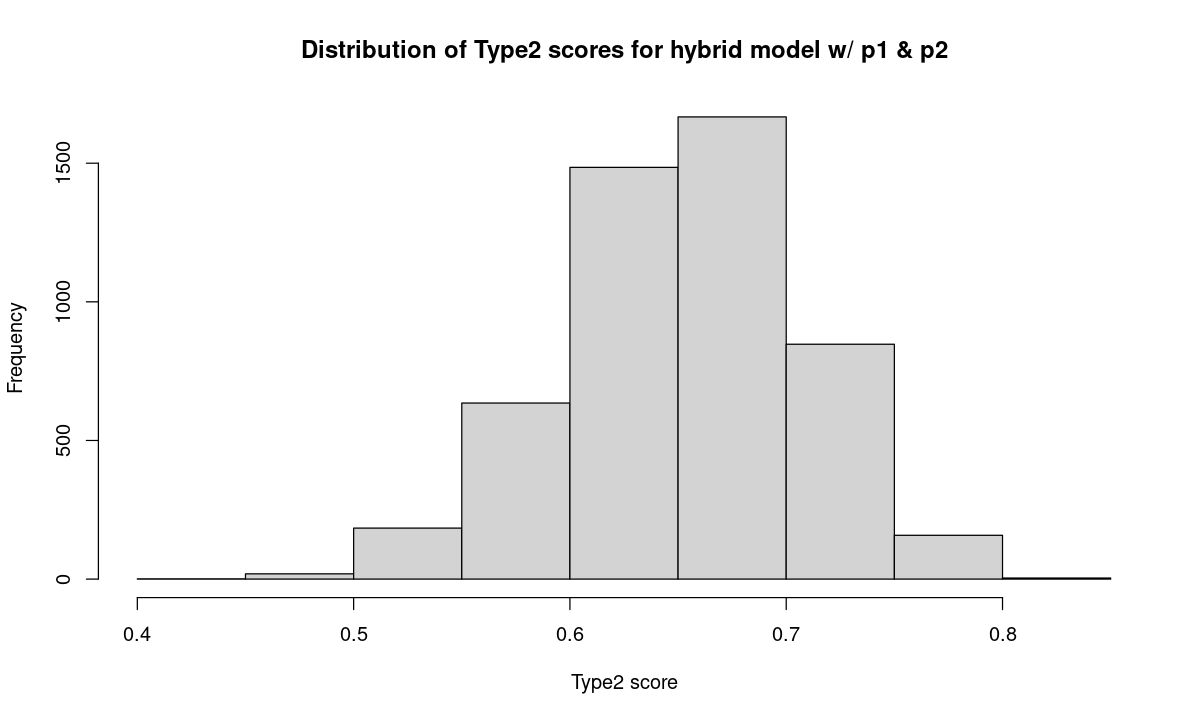

In [55]:
# Histogram of the Type2 scores for the hybrid model

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ p1 & p2")


In [56]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 8.59
paste0("FN StdDev: ", as.character(FN_sd))
# 2.53
""
summary(dat_result$FN)


[1] "FN mean: 8.5908"

[1] "FN StdDev: 2.5288"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    8.00    8.59   10.00   18.00 

In [57]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 16.22
paste0("FP StdDev: ", as.character(FP_sd))
# 3.19
""
summary(dat_result$FP)


[1] "FP mean: 16.2208"

[1] "FP StdDev: 3.1919"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    6.0    14.0    16.0    16.2    18.0    31.0 

## Summary info for base k-means model with weights

In [58]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the base k-means model with weights.

get_cvScores_kmBase <- function(traindat, valdat) {
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.59, 0.27, 0.14)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names= rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled), row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [61]:
# Get scores for the base k-means model (with weights).

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.45 mins


Time difference of 3.45 mins

In [62]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5000,0.6500,0.5600,8,20
4782--2,0.6567,0.7125,0.6790,6,17
4782--3,0.6061,0.6750,0.6337,10,16
4782--4,0.6977,0.6750,0.6886,2,24
4782--5,0.7294,0.7125,0.7226,6,17
9275--1,0.6286,0.6750,0.6472,8,18


In [63]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6447
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0600
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6447"

[1] "fscore StdDev: 0.06"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.400   0.606   0.648   0.645   0.686   0.830 

In [64]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6838
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0465
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6838"

[1] "accuracy StdDev: 0.0465"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.525   0.650   0.688   0.684   0.713   0.838 

In [65]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6603
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0522
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6603"

[1] "Type2 StdDev: 0.0522"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.463   0.626   0.662   0.660   0.696   0.831 

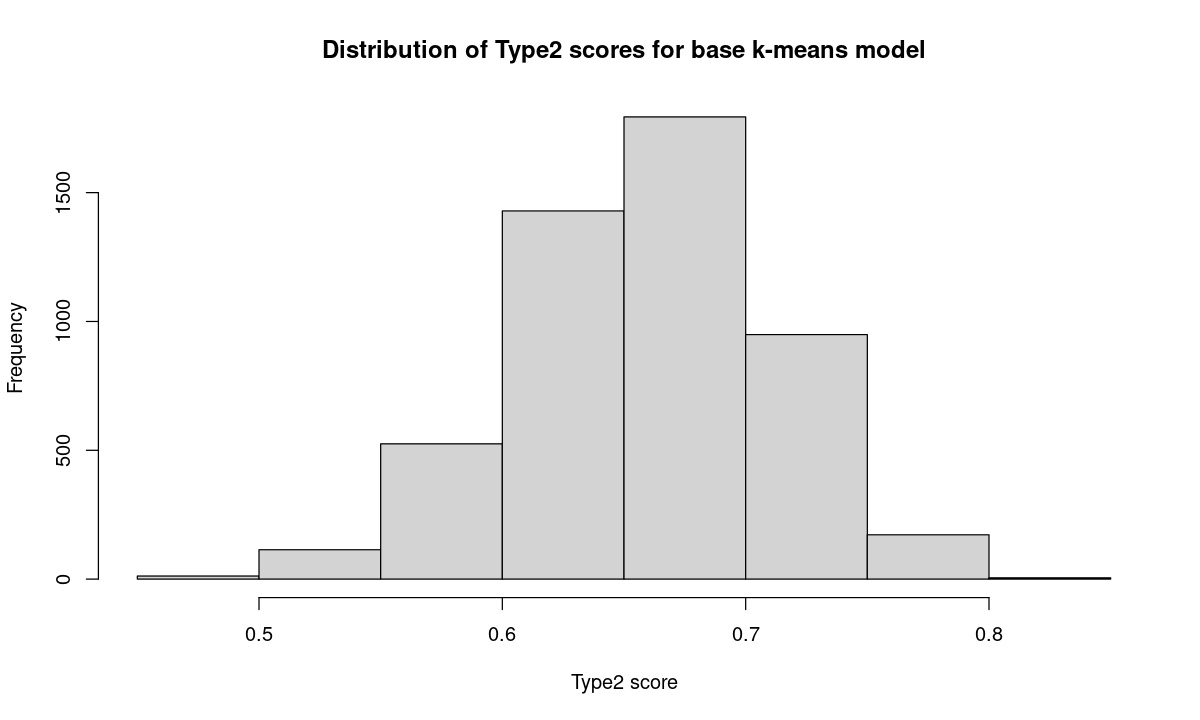

In [66]:
# Histogram of the Type2 scores for the base k-means model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for base k-means model")


In [67]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 6.56
paste0("FN StdDev: ", as.character(FN_sd))
# 2.17
""
summary(dat_result$FN)


[1] "FN mean: 6.5628"

[1] "FN StdDev: 2.1733"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    5.00    6.00    6.56    8.00   16.00 

In [68]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 18.73
paste0("FP StdDev: ", as.character(FP_sd))
# 3.37
""
summary(dat_result$FP)


[1] "FP mean: 18.7348"

[1] "FP StdDev: 3.3714"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0    16.0    19.0    18.7    21.0    32.0 

## Summary info for hybrid model with prob01

In [69]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column.

get_cvScores_kmp1 <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.30, 0.25, 0.34, 0.11)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled, row.names=rownames(valdat))
    
    # Compute the prob01 column.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [71]:
# Get scores for the hybrid model with prob01.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4 mins


Time difference of 4.02 mins

In [72]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5660,0.7125,0.6246,7,16
4782--2,0.6000,0.7000,0.6400,10,14
4782--3,0.5938,0.6750,0.6263,11,15
4782--4,0.6914,0.6875,0.6898,4,21
4782--5,0.6923,0.7000,0.6954,10,14
9275--1,0.6349,0.7125,0.6659,10,13


In [73]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6338
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0620
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6338"

[1] "fscore StdDev: 0.062"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.340   0.594   0.638   0.634   0.676   0.835 

In [74]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6939
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0461
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6939"

[1] "accuracy StdDev: 0.0461"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.512   0.662   0.700   0.694   0.725   0.838 

In [75]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6578
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0532
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6578"

[1] "Type2 StdDev: 0.0532"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.429   0.623   0.659   0.658   0.695   0.836 

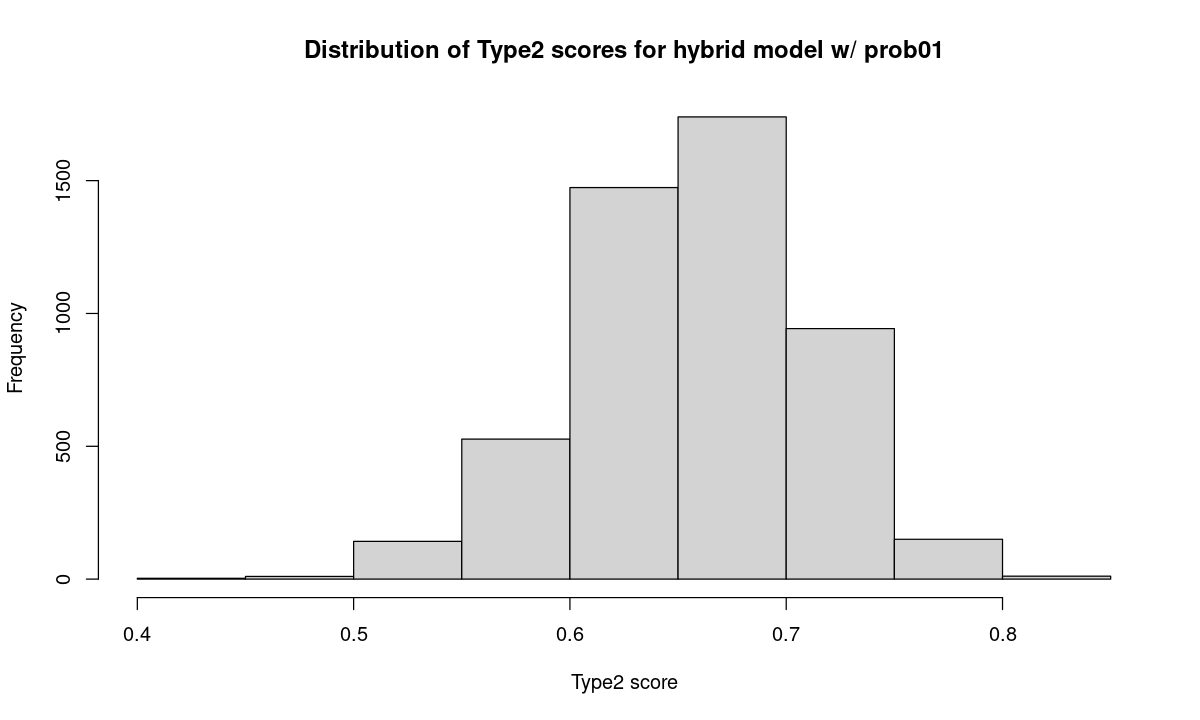

In [76]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01")


In [77]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 8.35
paste0("FN StdDev: ", as.character(FN_sd))
# 2.45
""
summary(dat_result$FN)


[1] "FN mean: 8.3532"

[1] "FN StdDev: 2.4483"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    8.00    8.35   10.00   17.00 

In [78]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 16.13
paste0("FP StdDev: ", as.character(FP_sd))
# 3.17
""
summary(dat_result$FP)


[1] "FP mean: 16.1342"

[1] "FP StdDev: 3.1684"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    6.0    14.0    16.0    16.1    18.0    30.0 

## Summary info for svm02

In [79]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the svm02 model.

get_cvScores_svm02 <- function(traindat, valdat) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data=train_scaled, kernel="radial",
                  gamma= 0.008, cost= 20, scale=FALSE, probability=TRUE)
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(test_scaled, row.names=rownames(valdat))
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    fscore <- round(get_fscore(mat), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [81]:
# Get scores for the svm02 model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 36.82 secs


Time difference of 36.82 secs

In [82]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5556,0.7000,0.6134,17,7
4782--2,0.6102,0.7125,0.6511,13,10
4782--3,0.5517,0.6750,0.6010,12,14
4782--4,0.7013,0.7125,0.7058,18,5
4782--5,0.6761,0.7125,0.6907,10,13
9275--1,0.6102,0.7125,0.6511,11,12


In [84]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6307
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0639
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6307"

[1] "fscore StdDev: 0.0639"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.361   0.588   0.635   0.631   0.676   0.831       2 

In [85]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7047
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0472
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7047"

[1] "accuracy StdDev: 0.0472"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.438   0.675   0.713   0.705   0.738   0.863 

In [86]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6603
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0551
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6603"

[1] "Type2 StdDev: 0.0551"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.421   0.623   0.662   0.660   0.698   0.844       2 

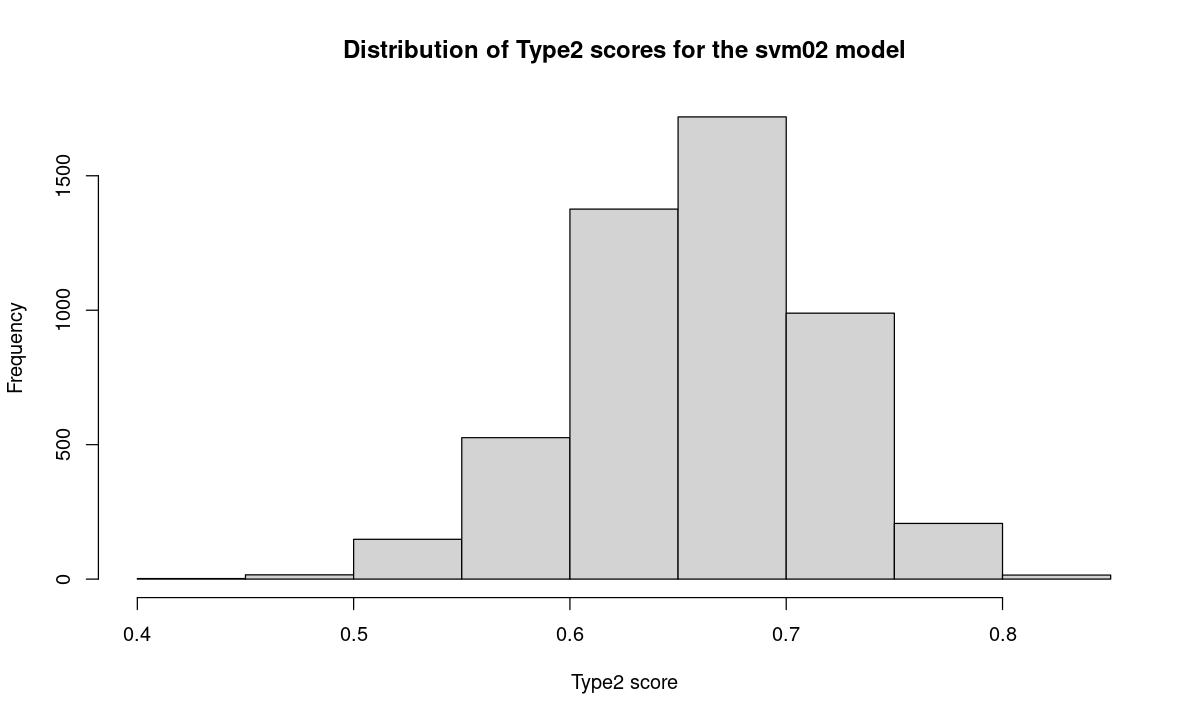

In [87]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the svm02 model")


In [88]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 14.18
paste0("FN StdDev: ", as.character(FN_sd))
# 3.57
""
summary(dat_result$FN)


[1] "FN mean: 14.178"

[1] "FN StdDev: 3.5682"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    12.0    14.0    14.2    16.0    30.0 

In [89]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.44
paste0("FP StdDev: ", as.character(FP_sd))
# 3.07
""
summary(dat_result$FP)


[1] "FP mean: 9.4424"

[1] "FP StdDev: 3.0732"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.44   11.00   45.00 

## Summary info for gbclf_best

In [20]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the gbclf_best model.

get_cvScores_gbclf <- function(traindat, valdat) {
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    
    preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}

In [22]:
# Get summary scores for gbclf_best.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 28.8 secs


Time difference of 28.8 secs

In [23]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5833,0.7500,0.6500,8,12
4782--2,0.5614,0.6875,0.6118,12,13
4782--3,0.5926,0.7250,0.6456,14,8
4782--4,0.6471,0.7000,0.6683,10,14
4782--5,0.6562,0.7250,0.6837,16,6
9275--1,0.6441,0.7375,0.6815,11,10


In [24]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6058
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0681
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6058"

[1] "fscore StdDev: 0.0681"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.279   0.561   0.610   0.606   0.655   0.842 

In [25]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.714
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.046
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.714"

[1] "accuracy StdDev: 0.046"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.506   0.688   0.713   0.714   0.750   0.887 

In [26]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6491
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0567
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6491"

[1] "Type2 StdDev: 0.0567"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.412   0.612   0.651   0.649   0.688   0.860 

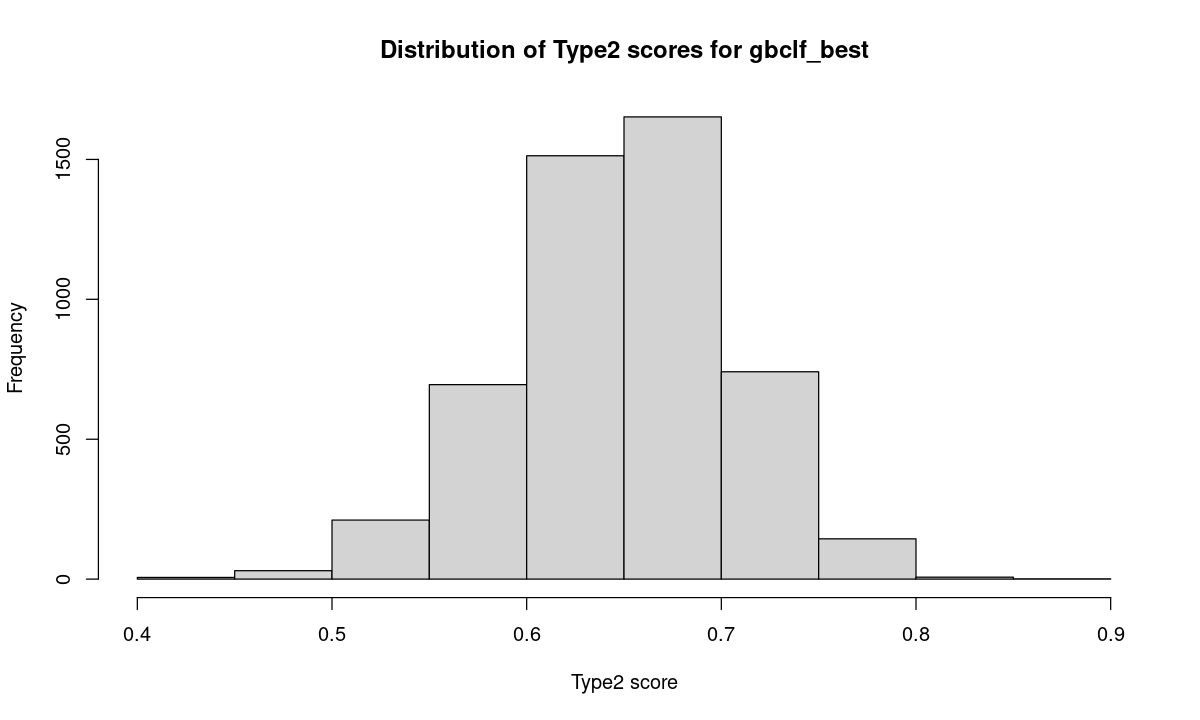

In [27]:
# Histogram of the Type2 scores for gbclf_best.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for gbclf_best")


In [28]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.01
paste0("FN StdDev: ", as.character(FN_sd))
# 3.23
""
summary(dat_result$FN)


[1] "FN mean: 12.0116"

[1] "FN StdDev: 3.2301"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      10      12      12      14      26 

In [29]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 10.87
paste0("FP StdDev: ", as.character(FP_sd))
# 3.28
""
summary(dat_result$FP)


[1] "FP mean: 10.8666"

[1] "FP StdDev: 3.2844"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     9.0    11.0    10.9    13.0    26.0 

## Summary info for the g03 logistic model

In [30]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order. 
# (First alter get_cvInfo to call this function.)

get_cvScores_g03 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    preds <- suppressWarnings(predict(g03mod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [32]:
# Get summary scores for the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 28.12 secs


Time difference of 28.12 secs

In [33]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5833,0.7500,0.6500,8,12
4782--2,0.6207,0.7250,0.6624,10,12
4782--3,0.5556,0.7000,0.6134,15,9
4782--4,0.6761,0.7125,0.6907,8,15
4782--5,0.6364,0.7000,0.6618,16,8
9275--1,0.6552,0.7500,0.6931,11,9


In [34]:
fscore_mean <- round(mean(dat_result$fscore, na.rm=TRUE), 4)
fscore_sd <- round(sd(dat_result$fscore, na.rm=TRUE), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6177
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0666
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6177"

[1] "fscore StdDev: 0.0666"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.318   0.576   0.621   0.618   0.667   0.829 

In [35]:
Acc_mean <- round(mean(dat_result$Acc, na.rm=TRUE), 4)
Acc_sd <- round(sd(dat_result$Acc, na.rm=TRUE), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7163
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.046
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7163"

[1] "accuracy StdDev: 0.046"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.550   0.688   0.713   0.716   0.750   0.875 

In [36]:
Type2_mean <- round(mean(dat_result$Type2, na.rm=TRUE), 4)
Type2_sd <- round(sd(dat_result$Type2, na.rm=TRUE), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6572
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0559
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6572"

[1] "Type2 StdDev: 0.0559"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.434   0.621   0.659   0.657   0.695   0.843 

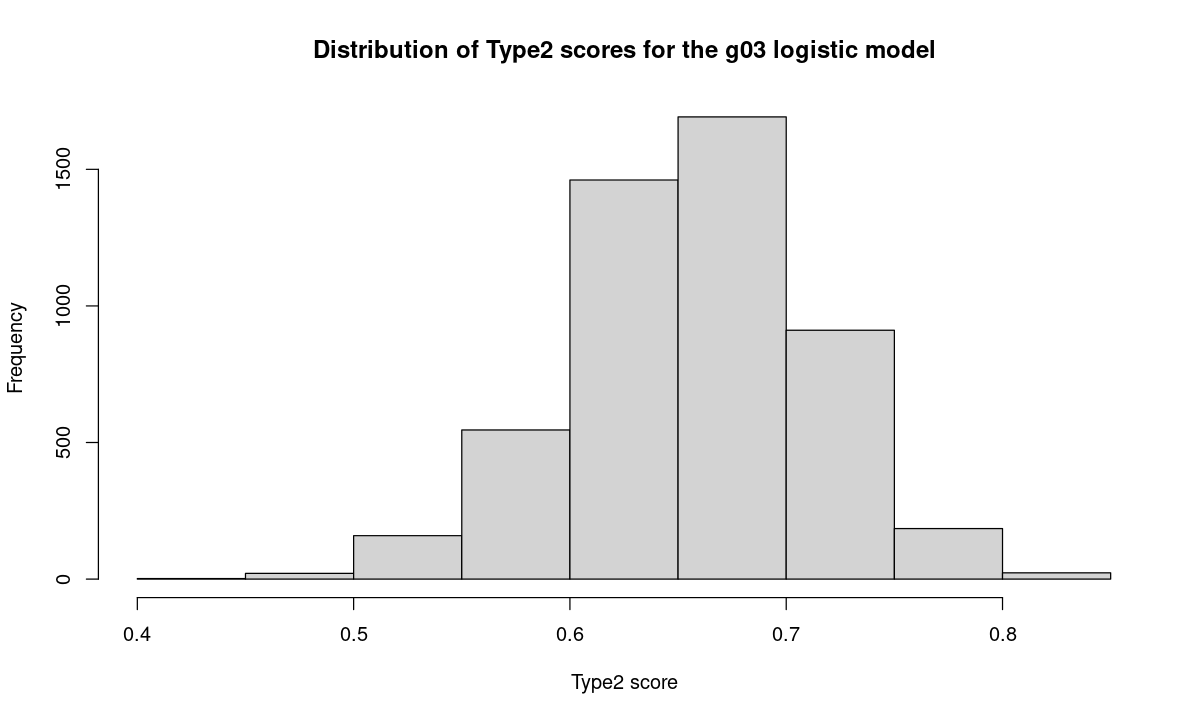

In [37]:
# Histogram of the Type2 scores for g03.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the g03 logistic model")


In [38]:
FN_mean <- round(mean(dat_result$FN, na.rm=TRUE), 4)
FN_sd <- round(sd(dat_result$FN, na.rm=TRUE), 4)
paste0("FN mean: ", as.character(FN_mean))
# 11.26
paste0("FN StdDev: ", as.character(FN_sd))
# 3.05
""
summary(dat_result$FN)


[1] "FN mean: 11.2552"

[1] "FN StdDev: 3.0491"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     9.0    11.0    11.3    13.0    22.0 

In [39]:
FP_mean <- round(mean(dat_result$FP, na.rm=TRUE), 4)
FP_sd <- round(sd(dat_result$FP, na.rm=TRUE), 4)
paste0("FP mean: ", as.character(FP_mean))
# 11.44
paste0("FP StdDev: ", as.character(FP_sd))
# 3.35
""
summary(dat_result$FP)


[1] "FP mean: 11.4426"

[1] "FP StdDev: 3.3477"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     9.0    11.0    11.4    14.0    27.0 

## Summary table for Section 5 results

In [40]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part2.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  6 10

In [41]:
# The following table is a summary of all the 
# Section 5 results.  The Type2 score is a
# weighted average of accuracy (40%) and f-score (60%).

results


,fscore,fscore_sd,Type2,Type2_sd,accuracy,acc_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
svm02,0.6307,0.0639,0.6603,0.0551,0.7047,0.0472,14.18,3.57,9.44,3.07
k-means,0.6447,0.0600,0.6603,0.0522,0.6838,0.0465,6.56,2.17,18.73,3.37
km_p1,0.6338,0.0620,0.6578,0.0532,0.6939,0.0461,8.35,2.45,16.13,3.17
km_p1p2,0.6282,0.0632,0.6528,0.0543,0.6899,0.0469,8.59,2.53,16.22,3.19
gbclf,0.6058,0.0681,0.6491,0.0567,0.7140,0.0460,12.01,3.23,10.87,3.28
g03,0.6177,0.0666,0.6572,0.0559,0.7163,0.0460,11.26,3.05,11.44,3.35


## Section Comments

For the average accuracy score, the g03 model outperforms gbclf_best, and gbclf_best outperforms svm02.  It is worth getting performance numbers for a hybrid model with the prob01 column constructed from g03 probabilities.

However, note that for the median accuracy score, g03, svm02, and gbclf_best *all have the same score* of 71.3%.

# Section 6: Construct hybrid model with prob01 from g03

In [70]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1_g03 <- function(traindat, valdat, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [45]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [46]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
11425,0.33,0.27,0.17,0.23
7201,0.35,0.27,0.19,0.19
22165,0.37,0.15,0.15,0.33
20509,0.27,0.21,0.21,0.31
23329,0.25,0.13,0.29,0.33
22057,0.29,0.25,0.13,0.33


In [47]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 20.76 secs (for 10 rows)


Time difference of 20.76 secs

In [48]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [49]:
dfc01[best_params,]

best_Type2


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
22057,0.29,0.25,0.13,0.33


[1] 0.66352

In [50]:
# Find the best weights of those in dfc01 (1469 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.03 hours


[1] "Start time: 2021-04-17 15:37:42"

Time difference of 1.03 hours

In [51]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [52]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 24493 	0.13 	0.37	   0.15 	  0.35


best_Type2
# 0.6640


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
24493,0.13,0.37,0.15,0.35


[1] 0.66396

In [54]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.04, 0.16, by= 0.02)
lst[[2]] <- seq(0.34, 0.52, by= 0.02)
lst[[3]] <- seq(0.10, 0.18, by= 0.02)
lst[[4]] <- seq(0.32, 0.52, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  209     4


[1] 209   4

In [55]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.  (Setting each of the weight 
# coefficients to 1 is essentially equivalent to
# setting each of the 4 weights to 0.25, although
# small differences can appear in the resultant
# score.)  

# NOTE: the result we get from this test is much 
# better than testing against the test set, since
# this test is the equivalent of 100 such tests.

dfc02 <- rbind(dfc02, rep(1,4))


In [56]:
# Find the best weights of those in dfc02 (210 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 9.16 mins


[1] "Start time: 2021-04-17 16:44:29"

Time difference of 9.16 mins

In [57]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [58]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 459   	0.10 	0.44	   0.12 	  0.34

best_Type2
# 0.6645


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
459,0.1,0.44,0.12,0.34


[1] 0.66453

In [59]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.08, 0.12, by= 0.01)
lst[[2]] <- seq(0.42, 0.47, by= 0.01)
lst[[3]] <- seq(0.10, 0.15, by= 0.01)
lst[[4]] <- seq(0.33, 0.37, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  92     4


[1] 92  4

In [60]:
# Find the best weights of those in dfc02 (210 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.99 mins


[1] "Start time: 2021-04-17 16:59:49"

Time difference of 3.99 mins

In [61]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [62]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 99    	0.11 	0.43	   0.13 	  0.33

best_Type2
# 0.6648


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
99,0.11,0.43,0.13,0.33


[1] 0.66476

### Summary info for hybrid model with prob01 constructed from g03

In [63]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column.

get_cvScores_kmp1_g03 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    #############################
    # Transform and scale training set data.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  
    
    wghts <- c(0.11, 0.43, 0.13, 0.33)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [65]:
# Get scores for the hybrid model with prob01 constructed 
# from the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4 mins


Time difference of 3.95 mins

In [66]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6512,0.8125,0.7157,8,7
4782--2,0.6071,0.7250,0.6543,11,11
4782--3,0.5532,0.7375,0.6269,17,4
4782--4,0.6667,0.7125,0.6850,9,14
4782--5,0.6349,0.7125,0.6659,17,6
9275--1,0.6429,0.7500,0.6857,12,8


In [67]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6159
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0692
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6159"

[1] "fscore StdDev: 0.0692"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.244   0.571   0.621   0.616   0.667   0.830 

In [68]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7321
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0455
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7321"

[1] "accuracy StdDev: 0.0455"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.550   0.700   0.738   0.732   0.762   0.887 

In [69]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6624
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0571
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6624"

[1] "Type2 StdDev: 0.0571"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.388   0.625   0.664   0.662   0.701   0.853 

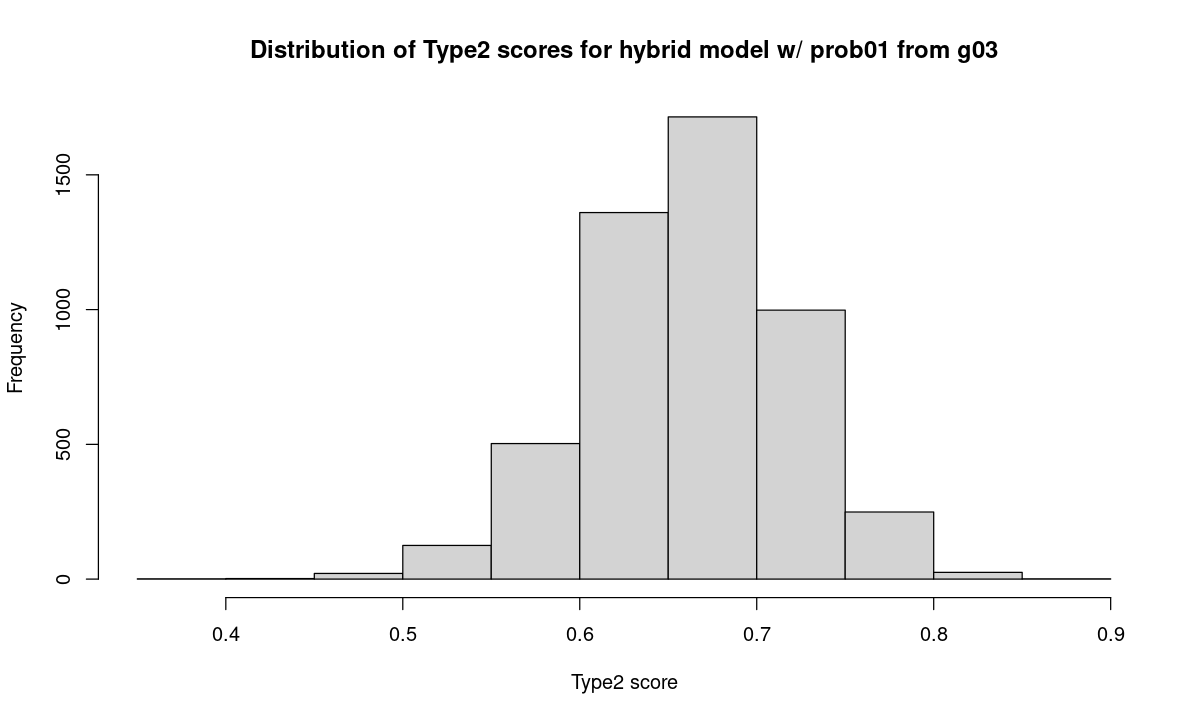

In [70]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01 from g03")


In [71]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.41
paste0("FN StdDev: ", as.character(FN_sd))
# 3.11
""
summary(dat_result$FN)


[1] "FN mean: 12.4068"

[1] "FN StdDev: 3.1133"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    10.0    12.0    12.4    14.0    24.0 

In [72]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.02
paste0("FP StdDev: ", as.character(FP_sd))
# 3.05
""
summary(dat_result$FP)


[1] "FP mean: 9.0238"

[1] "FP StdDev: 3.0482"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.02   11.00   20.00 

## Summary table for Section 6 results

In [73]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part2b.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  7 10

In [ ]:
#&* Bookmark

In [74]:
# The following table is a summary of all the 
# results from Sections 5 and 6.  Recall that
# the Type2 score is 60% f-score and 40% accuracy.

results


,fscore,fscore_sd,Type2,Type2_sd,accuracy,acc_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
svm02,0.6307,0.0639,0.6603,0.0551,0.7047,0.0472,14.18,3.57,9.44,3.07
k-means,0.6447,0.0600,0.6603,0.0522,0.6838,0.0465,6.56,2.17,18.73,3.37
km_p1,0.6338,0.0620,0.6578,0.0532,0.6939,0.0461,8.35,2.45,16.13,3.17
km_p1p2,0.6282,0.0632,0.6528,0.0543,0.6899,0.0469,8.59,2.53,16.22,3.19
gbclf,0.6058,0.0681,0.6491,0.0567,0.7140,0.0460,12.01,3.23,10.87,3.28
g03,0.6177,0.0666,0.6572,0.0559,0.7163,0.0460,11.26,3.05,11.44,3.35
km_g03,0.6159,0.0692,0.6624,0.0571,0.7321,0.0455,12.41,3.11,9.02,3.05


# Final Comments, Part 2

If we go by average accuracy scores or median accuracy scores, km_g03 is the best model of those surveyed.  However, it has the next-to-lowest f-score in the above table.  The f-score makes up 60% of the Type2 score.  After km_g03, the models with the next best Type2 scores are svm02 and the base k-means model, both with a score of 0.6603.  The Z-statistic for the difference in means is 1.92, yielding a two-tailed p-value of 0.055.  From the standpoint of the Type2 score, then, there is **not** a statistically significant difference between km_g03, svm02, and the base k-means model.  (This is true even if we look at the Type2 median scores for these models.)  But if we re-weight the Type2 score so that it is 50% f-score and 50% accuracy, then the nearest competitor to km_g03 is svm02 (0.6740 vs 0.6677).  The Z-statistic for this difference in means is 5.614, yielding a two-tailed p-value of 1.98e-08.

It may be that the way to construct a better model from the base k-means model using a prob01 column is to generate the probabilities for prob01 from the model, among those surveyed, with the best average accuracy score.  (Recall that svm02, g03, and gbclf_best all have the same median accuracy score over 5000 folds: an accuracy of 71.3%.  The median accuracy score for km_g03 is 73.8%.)  It helps, of course, if this accuracy score is better than what we already have for the base k-means model.  But it is not clear to me that this is a requirement.

From the above table we see that km_g03 is now the best model for the downer cow dataset if accuracy is the criterion, or if we give equal weight to f-score and accuracy.  km_g03 has a mean accuracy score that is 1.6 percentage points better than the next best model, g03.  Comparing the mean accuracy for g03 with that of km_g03, the Z-statistic for the difference in these means is 17.27.  This gives us a two-tailed p-value less than 2e-16.

Overall, there is reason to say that km_g03 is the best model of those in the table above.  Although it does not have a great f-score, it performs much better than the other models in terms of accuracy.  It tends to have fewer false positives than false negatives.  Relative to the other models in our table, it has the lowest standard deviation for its accuracy score, although it has the highest standard deviation for its f-score.  Compared to the other models, km_g03 also has the smallest average false positive rate, and the smallest standard deviation for its false positives.



                                     * * * * *

# Addendum

## Using tot.withinss to search for weights

When the k-means algorithm is applied to the data on downer cows, we ask the algorithm to give us 2 clusters because we are interested in only 2 clusters---distinguishing between the cows that survived and those that did not.  But we also see from the wss (within-group sum of squares) plot below, that a 2-cluster solution is optimal for our dataset regardless of our interest in distinguishing between survivors and non-survivors.  We might say that the dataset naturally lends itself to a 2-cluster solution.  The obvious reason for why this 2-cluster solution aligns fairly well with the Outcome levels is the fact that the data in our dataframe was collected with the purpose of distinguishing between the survivors and the non-survivors.  

In this section, I explore whether we can find optimal weights for the columns used in our k-means modeling by measuring the total within-group sum of squares.  In other words, can weights be optimized by minimizing the total within-group sum of squares?  If so, then we have another way to find optimal weights.  With the current dataset, this second approach is 7X faster than the first.  Thus, if it works, it will be the approach we may sometimes want to use when searching for optimal weights.  (It will not always be 7X faster.  This factor depends on the dataset and what we are trying to do with it.)


                                   * * * * *

In [ ]:
#&* Bookmark

In [12]:
# The following function is from Robert Kabacoff's "R in Action", pp.379-380.

wssplot <- function(data, title="", nc=15, seed=1233) {
    
    # wss[1] is just the total sum of squares when 
    # there is only one center.
    wss <- (nrow(data) - 1)*sum(apply(data, 2, var))
    for(i in 2:nc) {
        set.seed(seed)
        wss[i] <- sum(kmeans(data, centers=i, 
                             iter.max = 50, nstart = 25)$withinss)
    }
    plot(1:nc, wss, type='b', xlab="Number of clusters",
        ylab="Within groups sums of squares",
        main= title)
}


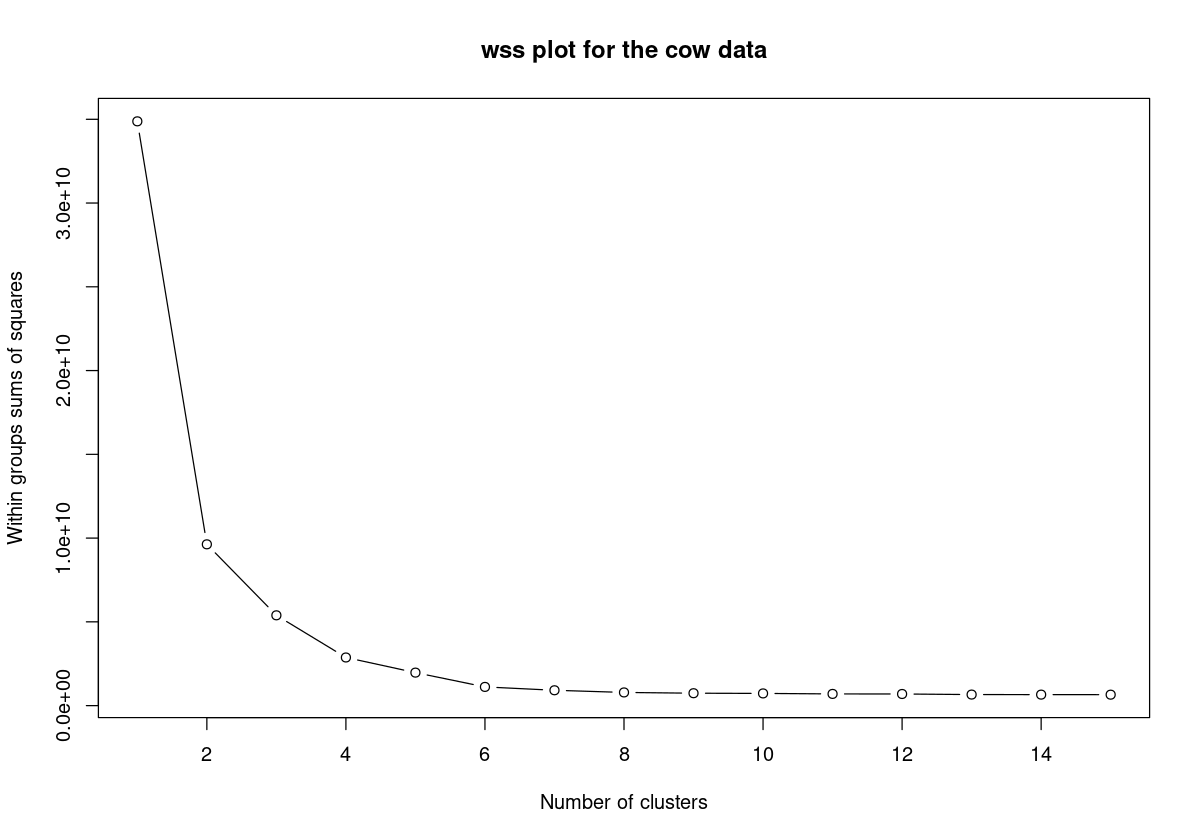

In [13]:
options(repr.plot.width= 10, repr.plot.height= 7)

# Remove the Outcome column from data before plotting.
wssplot(dat[, -1], title= "wss plot for the cow data")


In [ ]:
### COMMENT (on above graph):

# The largest gain we see in the reduction of within-group 
# sum of squares occurs when we have 2 clusters.  This 
# strongly suggests a 2-cluster solution to the 400 
# observations in dat.  The additional gain we would 
# get from a 3-cluster solution is negligible relative to
# the gain we see from a 2-cluster solution.  Thus, a 
# 2-cluster solution looks to be optimal for the downer 
# cow data.  Anything beyond 2 clusters will not be very
# helpful toward identifying the important groups in the
# dataset.

# Another way of describing how we use the above plot:
# we look for a "kink" in the curve; if there is one,
# that is the point at which we have an optimal number
# of clusters for the data we are working with.  See
# p. 513 of The Elements of Statistical Learning, 2nd
# Edition.


In [14]:
# Transform the data as if modeling for k-means.

df <- dat

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= df, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50)
    
df$prob01 <- as.numeric(g03$fitted)   
df$AST <- log(df$AST)
df$CK <- log(df$CK)
df$Daysrec <- sqrt(df$Daysrec)

df_scaled <- scale(df[, -1], center=TRUE, scale=TRUE)
df_scaled <- as.data.frame(cbind(df$Outcome, df_scaled),
                           row.names=rownames(df))
colnames(df_scaled) <- colnames(df)


# The following weights are optimal for the hybrid model
# when prob01 is constructed using g03.
wghts <- c(0.11, 0.43, 0.13, 0.33)
wghts <- wghts^0.5
names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
df2 <- t(t(df_scaled[, cols]) * as.numeric(wghts[cols]))
df_wghts <- cbind(as.numeric(df_scaled$Outcome), df2)
df_wghts <- as.data.frame(df_wghts)
colnames(df_wghts) <- c("Outcome", cols)
rownames(df_wghts) <- rownames(df_scaled)
    

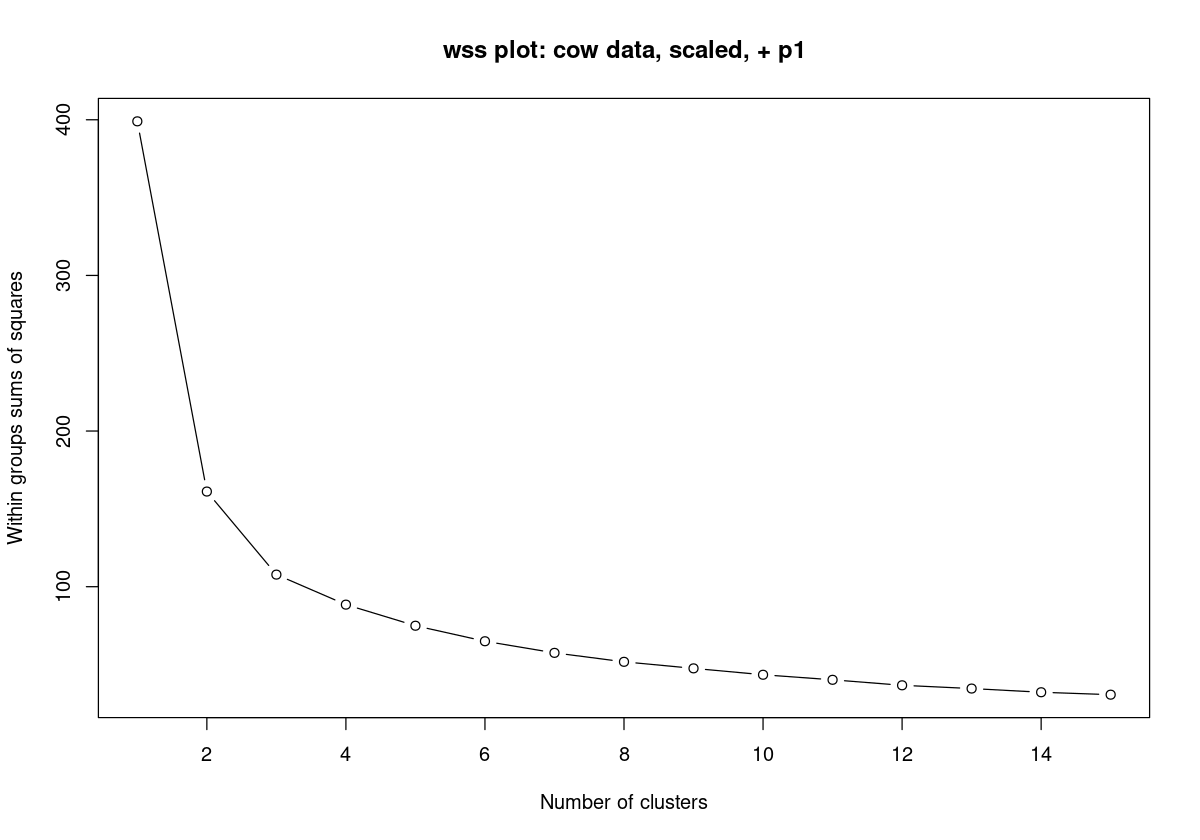

In [15]:
options(repr.plot.width= 10, repr.plot.height= 7)

# Remove the Outcome column from data before plotting.
wssplot(df_wghts[, -1], title= "wss plot: cow data, scaled, + p1")


### Can we use tot.withinss to help us find the best set of weights?

The best weights are those which enable our k-means model to do the best job generalizing to new data.  Thus, our method will still need to involve cross-validation.

I want to see if this approach to finding weights works and, if so, whether it is a faster way to find optimal weights.


                              * * * * *

In [16]:
# Function for computing the tot.withinss for each set of 
# weights in df_params (a dataframe, each row of which is
# a candidate set of weights).  The optimal set of weights
# will be the set that yields the smallest average (over
# the folds) for tot.withinss.
# This function is called from gridSearch07.

get_tot.withinss_g03 <- function(traindat, valdat, wghts) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    # Transform and scale training set data.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
     
    #############################
    # Prepare valdat.
    
    valdat$prob01 <- as.numeric(predict(g03mod, newdata=valdat))
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)
    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    
    # Apply weights to valdat.
    cols <- names(wghts)
    valdat_wghts <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    
    
    # Construct k-means model on valdat to get tot.withinss.
    kmod <- suppressWarnings(kmeans(valdat_wghts, 2, iter.max = 50, nstart=25))
    
    return(kmod$tot.withinss)
}


In [17]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.
# Because our training set is so small---only 400 records---we
# need to run the gridSearch over many seeds.  Otherwise, we 
# will not get a meaningful result.

gridSearch07 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "tot.withinss")
    datout$row <- params_rows <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    #############################
    # Partition the data into folds.
    
    segment_size <- round(dim(dat)[1]/folds)
    diff <- dim(dat)[1] - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == dim(dat)[1])
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are tot.withinss 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(i in 1:folds) {
            endpt <- startpt + segmentsv[i] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[i]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            train_list <- test_list <- vector("list", length= folds)
        
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            scores <- mcmapply(get_tot.withinss_g03gb, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the tot.withinss
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the tot.withinss scores
    # obtained for each set of parameters in df_params.
    datout$tot.withinss <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


In [18]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.04, 0.48, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  8030     4


[1] 8030    4

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [22]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.1 secs (for 10 rows)


Time difference of 3.1 secs

In [ ]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


In [ ]:
dfc01[best_params,]

best_tot.withinss


In [28]:
# Find the best weights of those in dfc01 (8030 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 46.12 mins  (= 0.3446 secs/row)


[1] "Start time: 2021-04-18 17:44:43"

Time difference of 46.12 mins

In [29]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [30]:
dfc01[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 527	0.44 	0.48	   0.04 	  0.04


best_tot.withinss
# 210.26


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
527,0.44,0.48,0.04,0.04


[1] 210.26

In [31]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.41, 0.47, by= 0.01)
lst[[2]] <- seq(0.45, 0.53, by= 0.01)
lst[[3]] <- seq(0.02, 0.07, by= 0.01)
lst[[4]] <- seq(0.02, 0.07, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  192     4


[1] 192   4

In [32]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.

dfc02 <- rbind(dfc02, rep(1,4))


In [33]:
# Find the best weights of those in dfc02 (193 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1 minute


[1] "Start time: 2021-04-18 18:46:05"

Time difference of 59.28 secs

In [34]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [37]:
# Find out the set of weights with the largest tot.withinss.

best_params02 <- dat_result[which(dat_result$tot.withinss == 
                                max(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params02)

best_tot.withinss02 <- round(dat_result[which(dat_result$tot.withinss == 
                                max(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


[1] 1

In [39]:
dfc02[best_params02,]

best_tot.withinss02
# 4,117  (this is largest value in dfc02)


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
193,1,1,1,1


[1] 4117.4

In [35]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 47    	0.45 	0.51	   0.02 	  0.02

best_tot.withinss
# 131.21


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
47,0.45,0.51,0.02,0.02


[1] 131.21

In [40]:
# Compare these weights with known best weights.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- c(0.45)
lst[[2]] <- c(0.51)
lst[[3]] <- c(0.02)
lst[[4]] <- c(0.02)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)


[1] 1 4

In [41]:
dfc03 <- rbind(dfc03, c(0.11, 0.43, 0.13, 0.33))
dfc03


AST,CK,Daysrec,prob01
<dbl>,<dbl>,<dbl>,<dbl>
0.45,0.51,0.02,0.02
0.11,0.43,0.13,0.33


In [43]:
# Find the best weights of those in dfc03 (2 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc03) 
stop <- Sys.time()
# round(stop - start, 2)

dat_result


row,tot.withinss
<chr>,<dbl>
1,131.41
2,1335.25


In [44]:
summary(df_scaled[, -1])


      AST                CK             Daysrec            prob01       
 Min.   :-2.1314   Min.   :-3.0256   Min.   :-1.2537   Min.   :-1.5298  
 1st Qu.:-0.7577   1st Qu.:-0.6954   1st Qu.:-1.2537   1st Qu.:-0.8579  
 Median :-0.0436   Median : 0.0123   Median :-0.0179   Median : 0.0658  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.7037   3rd Qu.: 0.6789   3rd Qu.: 0.8867   3rd Qu.: 0.9565  
 Max.   : 2.4651   Max.   : 2.3078   Max.   : 2.0157   Max.   : 1.6926  

In [ ]:
### COMMENT:

# The weights I am getting seem to depend very much on 
# the scaling.  I think I might get more sensible 
# weights using a min-max scaling.  (Based on prior
# experience working with weights for these variables,
# I am assuming we will get very poor cross-validation
# Type2 scores when using the weights of 0.45, 0.51, 
# 0.02, 0.02.)


In [45]:
df02 <- dat
df02_scaled <- scale(df02[, -1], center=TRUE, scale=TRUE)
summary(df02_scaled)


      AST               CK             Daysrec      
 Min.   :-0.829   Min.   :-0.5693   Min.   :-0.922  
 1st Qu.:-0.625   1st Qu.:-0.5109   1st Qu.:-0.922  
 Median :-0.356   Median :-0.3835   Median :-0.374  
 Mean   : 0.000   Mean   : 0.0000   Mean   : 0.000  
 3rd Qu.: 0.208   3rd Qu.:-0.0218   3rd Qu.: 0.722  
 Max.   : 4.973   Max.   : 7.0314   Max.   : 2.914  

In [46]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [ ]:
ans <- apply(df02_scaled, MARGIN=2, range01)
head(ans)


In [47]:
# This function is called from gridSearch07.

get_tot.withinss_g03_v02 <- function(traindat, valdat, wghts) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    # Scale training set data.  We need 'centers' and 'scales'
    # for scaling valdat.
    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
     
    #############################
    # Prepare valdat.
    
    valdat$prob01 <- as.numeric(predict(g03mod, newdata=valdat))
    
    # Scale valdat.
    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    
    # Move data between 0 and 1.  This is done so that the 
    # optimal weights do not depend so much on the ranges of
    # the variables.  [** FIXME: apply range02 here.  See Part 4 notebook. **]
    cols <- names(wghts)
    valdat_scaled02 <- apply(valdat_scaled, MARGIN=2, range01)
    colnames(valdat_scaled02) <- cols
    
    # Apply weights to valdat.
    valdat_wghts <- t(t(valdat_scaled02[, cols]) * as.numeric(wghts[cols]))
    
    # Construct k-means model on valdat to get tot.withinss.
    kmod <- suppressWarnings(kmeans(valdat_wghts, 2, iter.max = 50, nstart=25))
    
    return(kmod$tot.withinss)
}


In [49]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.86 secs (for 10 rows)


In [ ]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


In [ ]:
dfc01[best_params,]

best_tot.withinss


In [54]:
# Find the best weights of those in dfc01 (1469 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.13 mins  (= 0.3321 secs/row)

# This is 7X faster than the first approach which directly
# used cross-validation.  


[1] "Start time: 2021-04-18 19:50:30"

Time difference of 8.13 mins

In [55]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [56]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 26521 	0.13 	0.37	   0.13 	  0.37


best_tot.withinss
# 1.4402


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
26521,0.13,0.37,0.13,0.37


[1] 1.4402

In [58]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.06, 0.16, by= 0.02)
lst[[2]] <- seq(0.34, 0.50, by= 0.02)
lst[[3]] <- seq(0.06, 0.16, by= 0.02)
lst[[4]] <- seq(0.34, 0.50, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  208     4


[1] 208   4

In [59]:
# Find the best weights of those in dfc02 (208 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.08 mins


[1] "Start time: 2021-04-18 20:04:43"

Time difference of 1.08 mins

In [62]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [63]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 697    	0.06 	0.50	   0.06 	  0.38

best_tot.withinss
# 1.0439


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
697,0.06,0.5,0.06,0.38


[1] 1.0439

In [64]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.05, 0.09, by= 0.01)
lst[[2]] <- seq(0.48, 0.54, by= 0.01)
lst[[3]] <- seq(0.05, 0.09, by= 0.01)
lst[[4]] <- seq(0.35, 0.42, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  99     4


[1] 99  4

In [65]:
# Find the best weights of those in dfc02 (99 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 31.6 secs


[1] "Start time: 2021-04-18 20:10:08"

Time difference of 31.6 secs

In [66]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [67]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 206    	0.05 	0.54	   0.05 	  0.36

best_tot.withinss
# 0.9844


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
206,0.05,0.54,0.05,0.36


[1] 0.9844

In [ ]:
### COMMENT:

# We might be able to use this new method as a way to 
# close in on optimal weights.  We can first apply this
# method, then follow-up with the approach that directly
# relies on cross-validation.


### Test the 3 sets of weights with cross-validation

In [68]:
# Compare these weights with known best weights.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- c(0.06)
lst[[2]] <- c(0.50)
lst[[3]] <- c(0.06)
lst[[4]] <- c(0.38)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)

# These are our current best weights.
dfc03 <- rbind(dfc03, c(0.11, 0.43, 0.13, 0.33))
dfc03 <- rbind(dfc03, c(0.05, 0.54, 0.05, 0.36))
dfc03 <- rbind(dfc03, c(0.13, 0.37, 0.13, 0.37))
dfc03


[1] 1 4

AST,CK,Daysrec,prob01
<dbl>,<dbl>,<dbl>,<dbl>
0.06,0.50,0.06,0.38
0.11,0.43,0.13,0.33
0.05,0.54,0.05,0.36
0.13,0.37,0.13,0.37


In [72]:
# Find the best weights of those in dfc03, 
# using 101 seeds.

set.seed(1233)
seed_vector <- sample(1:9999, 101, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.55 mins


Time difference of 1.55 mins

In [74]:
datout <- cbind(dfc03, dat_result$Type2)
colnames(datout) <- c(colnames(dfc03), "Type2")
datout


AST,CK,Daysrec,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06,0.50,0.06,0.38,0.66062
0.11,0.43,0.13,0.33,0.66139
0.05,0.54,0.05,0.36,0.66053
0.13,0.37,0.13,0.37,0.65986


In [ ]:
### COMMENT:

# Note that we have the best cross-val score for the weights
# for which we would expect the best score, those found in
# Section 6 above.  The next best score is for the weights 
# in the first row.  But the Type2 score for the first-row
# weights is close enough to the Type2 scores for the weights
# in rows 3 and 4 that it is hard to say there is a real 
# difference in these scores.  Thus, if we were to switch over
# to gridSearch06, which tests weight combinations using
# Type2 cross-validation scores, from gridSearch07, we should
# probably start looking in the region around the weight
# combination found in row 4 above.


In [75]:
# Find the best weights of those in dfc03.  Here I
# am running with 201 seeds and a different starting
# seed.

set.seed(1913)
seed_vector <- sample(1:9999, 201, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.42 mins


Time difference of 3.42 mins

In [76]:
datout <- cbind(dfc03, dat_result$Type2)
colnames(datout) <- c(colnames(dfc03), "Type2")
datout


AST,CK,Daysrec,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06,0.50,0.06,0.38,0.66206
0.11,0.43,0.13,0.33,0.66230
0.05,0.54,0.05,0.36,0.66260
0.13,0.37,0.13,0.37,0.66094


In [77]:
# Find the best weights of those in dfc03, using
# 1000 seeds. 

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 16.81 mins


[1] "Start time: 2021-04-18 20:52:44"

Time difference of 16.81 mins

In [78]:
datout <- cbind(dfc03, dat_result$Type2)
colnames(datout) <- c(colnames(dfc03), "Type2")
datout


AST,CK,Daysrec,prob01,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06,0.50,0.06,0.38,0.66210
0.11,0.43,0.13,0.33,0.66238
0.05,0.54,0.05,0.36,0.66251
0.13,0.37,0.13,0.37,0.66124


In [ ]:
### COMMENT:

# The weights found using tot.withinss are competitive with the
# weights found directly through cross-validation methods.

# Let's compare the summary info for the current best set of
# weights with the previous best set of weights.


## Summary info for hybrid model with prob01 constructed from g03

Get scores for the hybrid model with the above best weights obtained using tot.withinss.  Then compare these scores with those for the hybrid model which used weights obtained directly from Type2 cross-validation scores.

In [79]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column.

get_cvScores_kmp1_g03 <- function(traindat, valdat) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    traindat$prob01 <- as.numeric(g03mod$fitted)
    
    
    #############################
    # Transform and scale traindat to obtain 'centers' and
    # 'scales'.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    # These are the best weights we currently have for this model.
    wghts <- c(0.05, 0.54, 0.05, 0.36)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols

       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- predict(g03mod, newdata=valdat)
    valdat$prob01 <- as.numeric(preds01_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat. 
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [81]:
# Get scores for the hybrid model with prob01 constructed 
# from the g03 logistic model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4 mins


Time difference of 4.01 mins

In [82]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6087,0.7750,0.6752,8,10
4782--2,0.6071,0.7250,0.6543,11,11
4782--3,0.5532,0.7375,0.6269,17,4
4782--4,0.6667,0.7125,0.6850,9,14
4782--5,0.6562,0.7250,0.6837,16,6
9275--1,0.6429,0.7500,0.6857,12,8


In [83]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6161
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0691
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6161"

[1] "fscore StdDev: 0.0691"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.244   0.571   0.621   0.616   0.667   0.828 

In [84]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7321
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0456
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7321"

[1] "accuracy StdDev: 0.0456"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.562   0.700   0.738   0.732   0.762   0.875 

In [85]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6625
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0571
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6625"

[1] "Type2 StdDev: 0.0571"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.388   0.625   0.666   0.663   0.702   0.847 

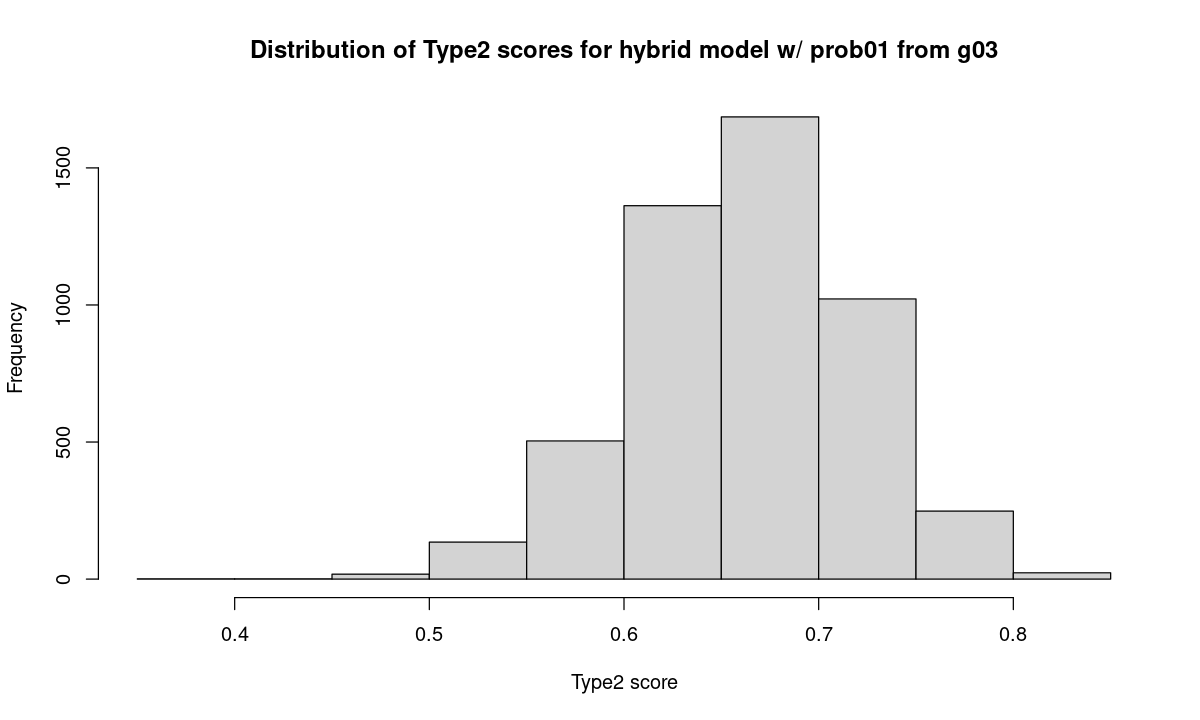

In [86]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01 from g03")


In [87]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.40
paste0("FN StdDev: ", as.character(FN_sd))
# 3.12
""
summary(dat_result$FN)


[1] "FN mean: 12.3972"

[1] "FN StdDev: 3.1209"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    10.0    12.0    12.4    14.0    24.0 

In [88]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.03
paste0("FP StdDev: ", as.character(FP_sd))
# 3.07
""
summary(dat_result$FP)


[1] "FP mean: 9.0316"

[1] "FP StdDev: 3.0735"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.03   11.00   22.00 

## Addendum Final Comments

The above summary scores, with the new set of weights, are essentially equivalent to the summary scores for the hybrid model using the weights found in Section 6.  This is a significant result because, for the downer cow dataset, we can find weights using tot.withinss 7X faster than when we make direct use of Type2 cross-validation scores.

Finding weights using tot.withinss will not work unless we carefully scale the data.  My min-max method of scaling happens to work for the downer cow data.  It remains to be seen whether we get similarly good results with the California housing data.  



                                      * * * * *

# Postscript

## Hybrid model with prob01 from g03 and prob02 from gbclf_best

It is worth looking into whether we can improve upon km_g03's scores by adding the probabilities generated by gbclf_best.  The gradient boosting model was used to create the best hybrid model in Part 1.

In [58]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1p2_v02 <- function(traindat, valdat, wghts) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    traindat$prob01 <- as.numeric(g03mod$fitted)
    traindat$prob02 <- as.numeric(preds02)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute prob01 and prob02.
    preds01_b <- predict(g03mod, newdata=valdat)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(preds01_b)
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [59]:
# This function is called from gridSearch07.

get_tot.withinss_g03gb <- function(traindat, valdat, wghts) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    traindat$prob01 <- as.numeric(g03mod$fitted)
    traindat$prob02 <- as.numeric(preds02)
    
    # Scale training set data.
    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Prepare valdat.
    
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(predict(g03mod, newdata=valdat))
    valdat$prob02 <- as.numeric(preds02_b) 
    
    # Scale valdat.
    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    
    # Move data between 0 and 1.  This is done so that the 
    # optimal weights do not depend so much on the ranges of
    # the variables.  [** FIXME: apply range02 here.  **]
    cols <- names(wghts)
    valdat_scaled02 <- apply(valdat_scaled, MARGIN=2, range01)
    colnames(valdat_scaled02) <- cols
    
    # Apply weights to valdat.
    valdat_wghts <- t(t(valdat_scaled02[, cols]) * as.numeric(wghts[cols]))
    
    # Construct k-means model on valdat to get tot.withinss.
    kmod <- suppressWarnings(kmeans(valdat_wghts, 2, iter.max = 50, nstart=15))
    
    return(kmod$tot.withinss)
}


In [61]:
# There are 5 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.10, 0.30, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  8801     5


[1] 8801    5

In [62]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47656,0.16,0.28,0.26,0.14,0.16
94566,0.28,0.20,0.10,0.20,0.22
26846,0.20,0.28,0.12,0.28,0.12
10006,0.22,0.24,0.20,0.24,0.10
136376,0.26,0.10,0.20,0.16,0.28
73086,0.12,0.10,0.30,0.30,0.18


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch07(seed_vector, dat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.37 secs (for 10 rows)


In [ ]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 2)


In [ ]:
dfc01[best_params,]

best_tot.withinss


In [66]:
# Find the best weights of those in dfc01 (8801 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.37 hours  (= 0.56 secs/row; nstart=15)


[1] "Start time: 2021-04-19 17:55:46"

Time difference of 1.37 hours

In [67]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [68]:
dfc01[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 13426 	0.20 	0.30	   0.10 	  0.30  	  0.10


best_tot.withinss
# 1.9178


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13426,0.2,0.3,0.1,0.3,0.1


[1] 1.9178

In [69]:
dat_result <- dat_result[order(dat_result$tot.withinss, decreasing=FALSE),]
top_six <- head(dat_result$row)
head(dat_result)


,row,tot.withinss
,<chr>,<dbl>
591,13426,1.9178
590,13416,1.9231
500,12096,1.9249
589,13406,1.9290
499,12086,1.9309
412,10766,1.9319


In [70]:
dfc01[top_six,]


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13426,0.20,0.30,0.1,0.30,0.1
13416,0.22,0.28,0.1,0.30,0.1
12096,0.22,0.30,0.1,0.28,0.1
13406,0.24,0.26,0.1,0.30,0.1
12086,0.24,0.28,0.1,0.28,0.1
10766,0.24,0.30,0.1,0.26,0.1


In [71]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.12, 0.20, by= 0.02)
lst[[2]] <- seq(0.30, 0.40, by= 0.02)
lst[[3]] <- seq(0.02, 0.12, by= 0.02)
lst[[4]] <- seq(0.30, 0.40, by=0.02)
lst[[5]] <- seq(0.02, 0.12, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  676     5


[1] 676   5

In [72]:
# Find the best weights of those in dfc02 (676 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.45 mins  (= 0.57 secs/row; nstart=15)


[1] "Start time: 2021-04-19 20:09:09"

Time difference of 6.45 mins

In [73]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [74]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#   928 	0.16 	0.40	   0.02 	  0.40  	  0.02


best_tot.withinss
# 1.0875


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
928,0.16,0.4,0.02,0.4,0.02


[1] 1.0875

In [75]:
dat_result <- dat_result[order(dat_result$tot.withinss, decreasing=FALSE),]
top_six <- head(dat_result$row)
head(dat_result)


,row,tot.withinss
,<chr>,<dbl>
77,928,1.0875
53,749,1.1023
76,924,1.1031
32,570,1.1158
52,745,1.1162
75,920,1.1167


In [76]:
dfc02[top_six,]


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
928,0.16,0.40,0.02,0.40,0.02
749,0.18,0.40,0.02,0.38,0.02
924,0.18,0.38,0.02,0.40,0.02
570,0.20,0.40,0.02,0.36,0.02
745,0.20,0.38,0.02,0.38,0.02
920,0.20,0.36,0.02,0.40,0.02


In [77]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.10, 0.16, by= 0.01)
lst[[2]] <- seq(0.40, 0.48, by= 0.01)
lst[[3]] <- seq(0.02, 0.05, by= 0.01)
lst[[4]] <- seq(0.40, 0.48, by=0.01)
lst[[5]] <- seq(0.02, 0.05, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  180     5


[1] 180   5

In [78]:
# Find the best weights of those in dfc03 (180 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.61 mins  (= 0.54 secs/row; nstart=15)


[1] "Start time: 2021-04-19 20:21:49"

Time difference of 1.61 mins

In [79]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [80]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#   43  	0.10 	0.46	   0.02 	  0.40  	  0.02


best_tot.withinss
# 1.0345


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,0.1,0.46,0.02,0.4,0.02


[1] 1.0345

In [81]:
dat_result <- dat_result[order(dat_result$tot.withinss, decreasing=FALSE),]
top_six <- head(dat_result$row)
head(dat_result)


,row,tot.withinss
,<chr>,<dbl>
7,43,1.0345
28,288,1.0352
45,533,1.0358
58,778,1.0365
67,1023,1.0371
72,1268,1.0378


In [82]:
dfc03[top_six,]


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,0.1,0.46,0.02,0.40,0.02
288,0.1,0.45,0.02,0.41,0.02
533,0.1,0.44,0.02,0.42,0.02
778,0.1,0.43,0.02,0.43,0.02
1023,0.1,0.42,0.02,0.44,0.02
1268,0.1,0.41,0.02,0.45,0.02


In [83]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.02, 0.10, by= 0.01)
lst[[2]] <- seq(0.45, 0.56, by= 0.01)
lst[[3]] <- seq(0.02, 0.03, by= 0.01)
lst[[4]] <- seq(0.35, 0.42, by=0.01)
lst[[5]] <- seq(0.02, 0.03, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
#  262     5


[1] 262   5

In [84]:
# Find the best weights of those in dfc04 (262 rows,
# 11 seeds, 5 folds).  

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch07(seed_vector, dat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.35 mins 


[1] "Start time: 2021-04-19 20:27:16"

Time difference of 2.35 mins

In [85]:
best_params <- dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$row
length(best_params)

best_tot.withinss <- round(dat_result[which(dat_result$tot.withinss == 
                                min(dat_result$tot.withinss, na.rm=TRUE)),]$tot.withinss, 4)


[1] 1

In [86]:
dfc04[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#  748  	0.02 	0.56	   0.02 	  0.38  	  0.02


best_tot.withinss
# 0.9472


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
748,0.02,0.56,0.02,0.38,0.02


[1] 0.9472

In [87]:
dat_result <- dat_result[order(dat_result$tot.withinss, decreasing=FALSE),]
top_six <- head(dat_result$row)
head(dat_result)


,row,tot.withinss
,<chr>,<dbl>
54,748,0.94725
72,955,0.94810
90,1162,0.94896
108,1369,0.94981
124,1576,0.95066
36,533,0.95785


In [88]:
dfc04[top_six,]


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
748,0.02,0.56,0.02,0.38,0.02
955,0.02,0.55,0.02,0.39,0.02
1162,0.02,0.54,0.02,0.40,0.02
1369,0.02,0.53,0.02,0.41,0.02
1576,0.02,0.52,0.02,0.42,0.02
533,0.03,0.56,0.02,0.37,0.02


### With suggested weights, get cross-val Type2 scores

In [89]:
# Compare all sets of weights from above.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- c(0.20)
lst[[2]] <- c(0.32)
lst[[3]] <- c(0.08)
lst[[4]] <- c(0.32)
lst[[5]] <- c(0.08)

start <- Sys.time()
dfc05 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc05)

# These are our current best weights.
dfc05 <- rbind(dfc05, c(0.16, 0.40, 0.02, 0.40, 0.02))
dfc05 <- rbind(dfc05, c(0.10, 0.46, 0.02, 0.40, 0.02))
dfc05 <- rbind(dfc05, c(0.02, 0.56, 0.02, 0.38, 0.02))
dfc05


[1] 1 5

AST,CK,Daysrec,prob01,prob02
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.20,0.32,0.08,0.32,0.08
0.16,0.40,0.02,0.40,0.02
0.10,0.46,0.02,0.40,0.02
0.02,0.56,0.02,0.38,0.02


In [90]:
# Find the best weights of those in dfc05.  Here I
# am running with 201 seeds and a different starting
# seed.

set.seed(1913)
seed_vector <- sample(1:9999, 201, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.29 mins


Time difference of 4.29 mins

In [91]:
datout <- cbind(dfc05, dat_result$Type2)
colnames(datout) <- c(colnames(dfc05), "Type2")
datout


AST,CK,Daysrec,prob01,prob02,Type2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.20,0.32,0.08,0.32,0.08,0.66181
0.16,0.40,0.02,0.40,0.02,0.66155
0.10,0.46,0.02,0.40,0.02,0.66190
0.02,0.56,0.02,0.38,0.02,0.66199


In [92]:
# Refine the search using gridSearch06 (cross-val Type2 scores)

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.02, 0.10, by=0.02)
lst[[2]] <- seq(0.46, 0.56, by=0.02)
lst[[3]] <- seq(0.02, 0.08, by=0.02)
lst[[4]] <- seq(0.32, 0.40, by=0.02)
lst[[5]] <- seq(0.02, 0.08, by=0.02)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc06)


[1] 271   5

In [115]:
# Find the best weights of those in dfc06 using 21
# seeds and a different starting seed.

set.seed(1711)
seed_vector <- sample(1:9999, 21, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 32.15 mins


In [94]:
best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [95]:
dfc06[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#  321  	0.02 	0.54	   0.06 	  0.36  	  0.02

best_Type2
# 0.66233


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
321,0.02,0.54,0.06,0.36,0.02


[1] 0.66233

In [96]:
dat_result <- dat_result[order(dat_result$Type2, decreasing=TRUE),]
top_six <- head(dat_result$row)
head(dat_result)


,row,Type2
,<chr>,<dbl>
45,321,0.66233
96,707,0.66220
162,1244,0.66217
20,173,0.66215
30,227,0.66214
13,112,0.66210


In [98]:
(dfc07 <- dfc06[top_six,])


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
321,0.02,0.54,0.06,0.36,0.02
707,0.04,0.52,0.08,0.32,0.04
1244,0.08,0.50,0.04,0.32,0.06
173,0.06,0.54,0.04,0.34,0.02
227,0.04,0.52,0.08,0.34,0.02
112,0.04,0.54,0.08,0.32,0.02


In [99]:
# Find the best weights of those in dfc07. 

set.seed(1711)
seed_vector <- sample(1:9999, 201, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, dat, dfc07) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6.53 mins


Time difference of 6.53 mins

In [100]:
datout <- cbind(dfc07, dat_result$Type2)
colnames(datout) <- c(colnames(dfc07), "Type2")
datout


,AST,CK,Daysrec,prob01,prob02,Type2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
321,0.02,0.54,0.06,0.36,0.02,0.66241
707,0.04,0.52,0.08,0.32,0.04,0.66260
1244,0.08,0.50,0.04,0.32,0.06,0.66209
173,0.06,0.54,0.04,0.34,0.02,0.66297
227,0.04,0.52,0.08,0.34,0.02,0.66243
112,0.04,0.54,0.08,0.32,0.02,0.66307


In [ ]:
### COMMENT:

# From the above table we can see that the best weights
# we have thus far are c(0.04, 0.54, 0.08, 0.32, 0.02)
# with a Type2 average cross-val score of 0.6631.


## Summary info for hybrid model with prob01 (g03) and prob02 (gbclf_best)

In [105]:
# This function is called from get_cvInfo.

get_cvScores_kmp1p2_v02 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
                  distribution= "bernoulli", shrinkage= 0.03)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    traindat$prob01 <- as.numeric(g03mod$fitted)
    traindat$prob02 <- as.numeric(preds02)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    # These are the best weights we currently have for the model.
    wghts <- c(0.04, 0.54, 0.08, 0.32, 0.02)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01","prob02")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat.
    
    # Compute prob01 and prob02.
    preds01_b <- predict(g03mod, newdata=valdat)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(preds01_b)
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat. 
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols

    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [107]:
# Get scores for this latest hybrid model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_cvInfo(seed_vector, dat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.26 mins


[1] "Start time: 2021-04-19 21:54:02"

Time difference of 5.26 mins

In [108]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6087,0.7750,0.6752,8,10
4782--2,0.6071,0.7250,0.6543,11,11
4782--3,0.5532,0.7375,0.6269,17,4
4782--4,0.6571,0.7000,0.6743,9,15
4782--5,0.6562,0.7250,0.6837,16,6
9275--1,0.6552,0.7500,0.6931,11,9


In [109]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6169
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0693
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6169"

[1] "fscore StdDev: 0.0693"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.244   0.571   0.621   0.617   0.667   0.828 

In [110]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7306
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0458
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7306"

[1] "accuracy StdDev: 0.0458"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.562   0.700   0.738   0.731   0.762   0.875 

In [111]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6624
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0573
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6624"

[1] "Type2 StdDev: 0.0573"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.388   0.625   0.664   0.662   0.702   0.847 

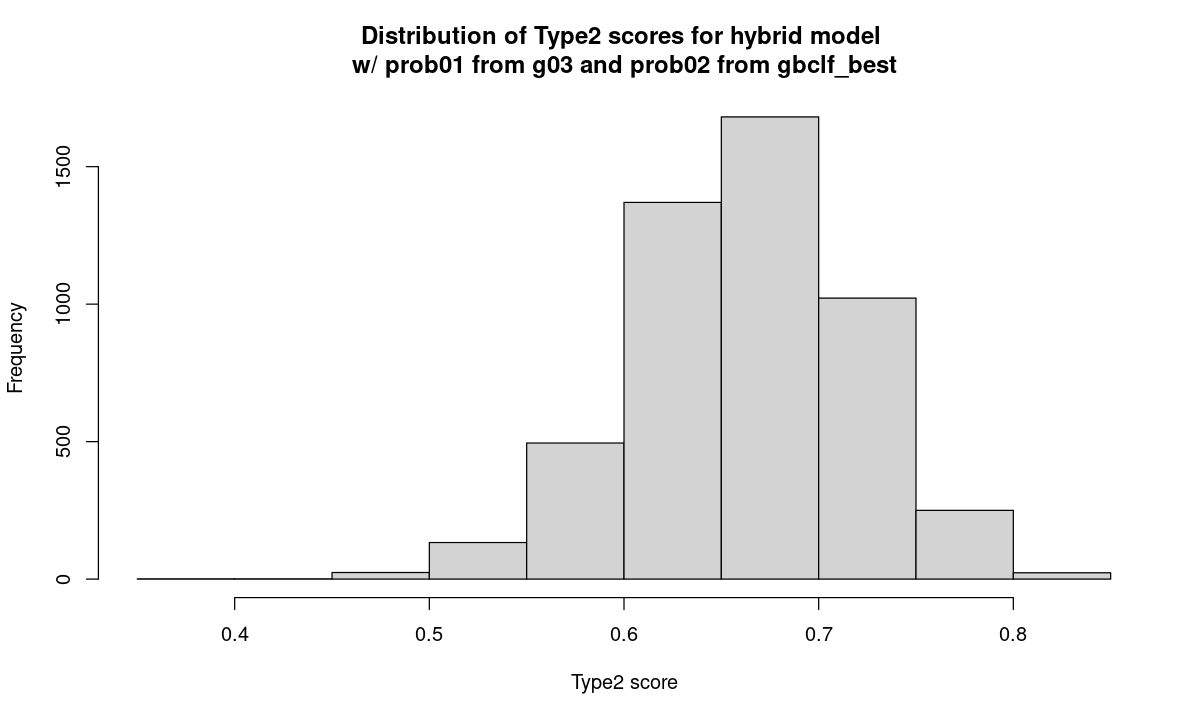

In [112]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model 
w/ prob01 from g03 and prob02 from gbclf_best")


In [113]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 12.23
paste0("FN StdDev: ", as.character(FN_sd))
# 3.09
""
summary(dat_result$FN)


[1] "FN mean: 12.2306"

[1] "FN StdDev: 3.0879"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    10.0    12.0    12.2    14.0    24.0 

In [114]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.325
paste0("FP StdDev: ", as.character(FP_sd))
# 3.11
""
summary(dat_result$FP)


[1] "FP mean: 9.3252"

[1] "FP StdDev: 3.1096"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.33   11.00   22.00 

## Summary for Postscript

The second probability column neither hurt nor helped the k-means hybrid model.  The scores for this latest hybrid model are essentially the same as those for km_g03.  The average Type2 score is exactly the same.  The extremely low weight on the prob02 column (I didn't permit the weight to go lower than 0.02) suggests that this added variable is not helping the model.

It is likely there is another classification model we could use for a prob02 column that would improve upon our current best model, km_g03.  We would just have to find the model.  It would probably have to have an accuracy greater than that of km_g03.  The f-score might also need to be higher.  Otherwise the new model for the prob02 column would not be adding the kind of information we need (or so one would think) in order to improve upon km_g03's scores.

This Postscript section shows how we can make use of tot.withinss when searching for optimal weights.  This second approach to finding weights is more efficient than directly relying upon Type2 cross-validation scores.



                                      * * * * * 